In [1]:
import sys,os, math, glob, time  
from builtins import zip  
sys.path.append('/data/fragosta/work/lsst/sims_maf_contrib-master/')  
import numpy as np
import pandas as pd  
import matplotlib.pyplot as plt  
import seaborn as sns  
from scipy.stats import norm, uniform  
from sklearn.neighbors import KernelDensity  
import lsst.sims.maf.slicers as slicers  
import lsst.sims.maf.metrics as metrics  
import lsst.sims.maf.metricBundles as metricBundles  
import lsst.sims.maf.db as db  
import lsst.sims.maf.plots as plots  
from lsst.sims.utils import equatorialFromGalactic, galacticFromEquatorial  
from lsst.sims.maf.metrics import BaseMetric, starDensity   
from lsst.sims.maf.utils import m52snr 
from opsimUtils import *  
from astropy.io import fits   
from sklearn.utils import shuffle
import sklearn.mixture as GMM  
import astrometry_metrics
%matplotlib inline 

In [2]:
from lsst.sims.maf.utils.opsimUtils import getSimData
from lsst.sims.maf.utils.mafUtils import radec2pix

In [3]:
your_username = 'fragosta'
if your_username == '': # do NOT put your username here, put it in the cell at the top of the notebook. 
         raise Exception('Please provide your username!  See the top of the notebook.') 

dbDir = '/home/idies/workspace/lsst_cadence/FBS_1.5/' 
outDir = '/home/idies/workspace/Storage/{}/persistent/MAFOutput/MetricData/Astrometry_loc'.format(your_username) 

if not os.path.exists(os.path.abspath(outDir)): 
     os.mkdir(os.path.abspath(outDir)) 
dbRuns = show_opsims(dbDir) 
opSimDbs, resultDbs = connect_dbs(dbDir, outDir)

In [4]:
U=np.arange(-100,100,5) 
W=np.arange(-100,100,5) 
V=np.arange(-100,100,5) 
def readfile( filename='', colsname=['']): 
    if 'csv' in filename: 
        #print('reading {}'.format(filename)) 
        data = pd.read_csv(filename, header=0, names = colsname ) 
    elif 'fits' in filename: 
        #print('reading {}'.format(filename)) 
        hdul = fits.open(filename) 
        data = hdul[1].data 
    elif ['txt', 'dat'] in filename: 
        #print('reading {}'.format(filename)) 
        data = {k:[] for k in colsname} 
        f = open(filename) 
        righe = f.readlines() 
        for line in righe: 
            line.split() 
            for i, k in enumerate(colsname): 
                data[k].append(float(line[i]))                 
    elif 'json'in filename: 
        print('not implemented to read .json extention') 
    return data 

In [17]:
names = ['ra', 'dec', 'seeing']    
npoint = 1  #  Note, we are going to loop over each object, so try not to make this a crazy huge number. 
transienobj = np.zeros(npoint, dtype=list(zip(names, [float]*len(names))))
# to random selection of position in the sky
l = 150.09671833  # np.random.rand(npoint)*2+30.
b = 2.18284020 # np.random.rand(npoint)*1+1.
#transienobj['ra'], transienobj['dec'] = equatorialFromGalactic(l,b) 
transienobj['ra'], transienobj['dec'] = l, b
#transObjects['seeing'] = np.random.rand(npo

In [177]:
surveyDuration = 2
filename = 'data.csv' 
colsname=['RA', 'DEC','g','g-r','Hg','PM','deltaX'] 
data = readfile(filename, colsname) 
#transienobj= pd.DataFrame({'ra':data['RA'], 'dec':data['DEC']}) 
metric1 = astrometry_metrics.LSPMmetric(f='g',m5Col='fiveSigmaDepth', mjdCol='observationStartMJD', seeingCol='seeingFwhmGeom',percentiles=[2.5,97.5,50],surveyduration = 2,dataout=True) 
metric2 = astrometry_metrics.TransienPM(Mmin=18,Mmax=24,f='g',m5Col='fiveSigmaDepth', mjdCol='observationStartMJD', seeingCol='seeingFwhmGeom',surveyduration=2) 
metric3 = astrometry_metrics.confusionmetric(filename='data.csv', colsname=['RA', 'DEC','g','g-r','Hg','PM','deltaX'],snr_lim=5,mode='distance', surveyduration = 2, MagIterLim=[2,3,1],m5Col='fiveSigmaDepth', mjdCol='observationStartMJD',filterCol='filter', seeingCol='seeingFwhmGeom',dataout=False) 
star = starDensity.StarDensityMetric()
#slicer3 = slicers.UserPointsSlicer(transienobj['ra'], transienobj['dec']) 
sqlconstraint ='night<{} and note not like  "DD%" '.format(365*surveyDuration) 
slicer = slicers.HealpixSlicer(nside=16) 
metricSky1 = metricBundles.MetricBundle(metric1,slicer,sqlconstraint) 
metricSky2 = metricBundles.MetricBundle(metric2,slicer,sqlconstraint) 
metricSky3 = metricBundles.MetricBundle(metric3,slicer,sqlconstraint)
starDens = metricBundles.MetricBundle(star,slicer,sqlconstraint)
bundleDict={'transient':metricSky2, 'confusion': metricSky3} 
#bundleDict={'like':metricSky1,'star':starDens}

Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes


In [ ]:
metricDataPath = '/home/idies/workspace/Storage/{}/persistent/MAFOutput/MetricData/Astrometry_loc'.format(your_username)

# below I am only going to run metrics on the first five opsims
for i, run in enumerate(dbRuns):
    print('##############\n')
    print('N_{}, {} is running\n'.format(i+1,run))
    print('##############\n')
    start_time = time.time()
    # must set run name for each opSim to store metric data into
    # separate files
    #metricSky1.setRunName(run)
    #starDens.setRunName(run)
    metricSky2.setRunName(run)
    metricSky3.setRunName(run)
    group = metricBundles.MetricBundleGroup(bundleDict, opSimDbs[run], metricDataPath, resultDbs[run])
    group.runAll()
    print( '--- {:.2f} minutes ---\n'.format((time.time() - start_time)/60))
    print('####################\n')

##############

N_1, dcr_nham1_ugri_v1.5_10yrs is running

##############

Querying database SummaryAllProps with constraint night<730 and note not like  "DD%"  for columns ['night', 'fieldDec', 'fiveSigmaDepth', 'filter', 'fieldRA', 'seeingFwhmGeom', 'observationStartMJD']
Found 408173 visits
Running:  ['transient', 'confusion']


/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/li

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
--- 3.96 minutes ---

####################

##############

N_2, rolling_mod6_sdf_0.20_v1.5_10yrs is running

##############

Querying database SummaryAllProps with constraint night<730 and note not like  "DD%"  for columns ['night', 'fieldDec', 'fiveSigmaDepth', 'filter', 'fieldRA', 'seeingFwhmGeom', 'observationStartMJD']
Found 410015 visits
Running:  ['transient', 'confusion']


/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/li

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
--- 3.97 minutes ---

####################

##############

N_3, wfd_depth_scale0.95_noddf_v1.5_10yrs is running

##############

Querying database SummaryAllProps with constraint night<730 and note not like  "DD%"  for columns ['night', 'fieldDec', 'fiveSigmaDepth', 'filter', 'fieldRA', 'seeingFwhmGeom', 'observationStartMJD']
Found 426982 visits
Running:  ['transient', 'confusion']


/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/li

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
--- 3.97 minutes ---

####################

##############

N_4, u60_v1.5_10yrs is running

##############

Querying database SummaryAllProps with constraint night<730 and note not like  "DD%"  for columns ['night', 'fieldDec', 'fiveSigmaDepth', 'filter', 'fieldRA', 'seeingFwhmGeom', 'observationStartMJD']
Found 381308 visits
Running:  ['transient', 'confusion']


/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/li

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
--- 3.62 minutes ---

####################

##############

N_5, footprint_stuck_rollingv1.5_10yrs is running

##############

Querying database SummaryAllProps with constraint night<730 and note not like  "DD%"  for columns ['night', 'fieldDec', 'fiveSigmaDepth', 'filter', 'fieldRA', 'seeingFwhmGeom', 'observationStartMJD']
Found 409922 visits
Running:  ['transient', 'confusion']


/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/li

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
--- 3.97 minutes ---

####################

##############

N_6, filterdist_indx4_v1.5_10yrs is running

##############

Querying database SummaryAllProps with constraint night<730 and note not like  "DD%"  for columns ['night', 'fieldDec', 'fiveSigmaDepth', 'filter', 'fieldRA', 'seeingFwhmGeom', 'observationStartMJD']
Found 426408 visits
Running:  ['transient', 'confusion']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
--- 3.60 minutes ---

####################

##############

N_7, wfd_depth_scale0.70_noddf_v1.5_10yrs is running

##############

Querying database SummaryAllProps with constraint night<730 and note not like  "DD%"  for columns ['night', 'fieldDec', 'fiveSigmaDepth', 'filter', 'fieldRA', 'seeingFwhmGeom', 'observationStartMJD']
Found 427572 visits
Running:  ['transient', 'confusion']


/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
--- 4.14 minutes ---

####################

##############

N_8, daily_ddf_v1.5_10yrs is running

##############

Querying database SummaryAllProps with constraint night<730 and note not like  "DD%"  for columns ['night', 'fieldDec', 'fiveSigmaDepth', 'filter', 'fieldRA', 'seeingFwhmGeom', 'observationStartMJD']
Found 385914 visits
Running:  ['transient', 'confusion']


/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/li

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
--- 3.78 minutes ---

####################

##############

N_9, alt_roll_mod2_dust_sdf_0.20_v1.5_10yrs is running

##############

Querying database SummaryAllProps with constraint night<730 and note not like  "DD%"  for columns ['night', 'fieldDec', 'fiveSigmaDepth', 'filter', 'fieldRA', 'seeingFwhmGeom', 'observationStartMJD']
Found 410902 visits
Running:  ['transient', 'confusion']


/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/li

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
--- 4.30 minutes ---

####################

##############

N_10, goodseeing_gz_v1.5_10yrs is running

##############

Querying database SummaryAllProps with constraint night<730 and note not like  "DD%"  for columns ['night', 'fieldDec', 'fiveSigmaDepth', 'filter', 'fieldRA', 'seeingFwhmGeom', 'observationStartMJD']
Found 408215 visits
Running:  ['transient', 'confusion']


/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/li

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
--- 4.07 minutes ---

####################

##############

N_11, filterdist_indx1_v1.5_10yrs is running

##############

Querying database SummaryAllProps with constraint night<730 and note not like  "DD%"  for columns ['night', 'fieldDec', 'fiveSigmaDepth', 'filter', 'fieldRA', 'seeingFwhmGeom', 'observationStartMJD']
Found 426119 visits
Running:  ['transient', 'confusion']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
--- 5.63 minutes ---

####################

##############

N_12, footprint_standard_goalsv1.5_10yrs is running

##############

Querying database SummaryAllProps with constraint night<730 and note not like  "DD%"  for columns ['night', 'fieldDec', 'fiveSigmaDepth', 'filter', 'fieldRA', 'seeingFwhmGeom', 'observationStartMJD']
Found 408236 visits
Running:  ['transient', 'confusion']


/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/li

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
--- 3.89 minutes ---

####################

##############

N_13, footprint_big_sky_dustv1.5_10yrs is running

##############

Querying database SummaryAllProps with constraint night<730 and note not like  "DD%"  for columns ['night', 'fieldDec', 'fiveSigmaDepth', 'filter', 'fieldRA', 'seeingFwhmGeom', 'observationStartMJD']
Found 409242 visits
Running:  ['transient', 'confusion']


/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/li

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
--- 3.69 minutes ---

####################

##############

N_14, footprint_bluer_footprintv1.5_10yrs is running

##############

Querying database SummaryAllProps with constraint night<730 and note not like  "DD%"  for columns ['night', 'fieldDec', 'fiveSigmaDepth', 'filter', 'fieldRA', 'seeingFwhmGeom', 'observationStartMJD']
Found 407984 visits
Running:  ['transient', 'confusion']


/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/li

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
--- 5.48 minutes ---

####################

##############

N_15, twilight_neo_mod4_v1.5_10yrs is running

##############

Querying database SummaryAllProps with constraint night<730 and note not like  "DD%"  for columns ['night', 'fieldDec', 'fiveSigmaDepth', 'filter', 'fieldRA', 'seeingFwhmGeom', 'observationStartMJD']
Found 452426 visits
Running:  ['transient', 'confusion']


/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/li

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
--- 4.03 minutes ---

####################

##############

N_16, goodseeing_gi_v1.5_10yrs is running

##############

Querying database SummaryAllProps with constraint night<730 and note not like  "DD%"  for columns ['night', 'fieldDec', 'fiveSigmaDepth', 'filter', 'fieldRA', 'seeingFwhmGeom', 'observationStartMJD']
Found 407705 visits
Running:  ['transient', 'confusion']


/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/li

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
--- 4.00 minutes ---

####################

##############

N_17, footprint_big_wfdv1.5_10yrs is running

##############

Querying database SummaryAllProps with constraint night<730 and note not like  "DD%"  for columns ['night', 'fieldDec', 'fiveSigmaDepth', 'filter', 'fieldRA', 'seeingFwhmGeom', 'observationStartMJD']
Found 410121 visits
Running:  ['transient', 'confusion']


/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/li

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
--- 3.91 minutes ---

####################

##############

N_18, dcr_nham2_ugr_v1.5_10yrs is running

##############

Querying database SummaryAllProps with constraint night<730 and note not like  "DD%"  for columns ['night', 'fieldDec', 'fiveSigmaDepth', 'filter', 'fieldRA', 'seeingFwhmGeom', 'observationStartMJD']
Found 408535 visits
Running:  ['transient', 'confusion']


/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/li

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
--- 4.05 minutes ---

####################

##############

N_19, short_exp_5ns_5expt_v1.5_10yrs is running

##############

Querying database SummaryAllProps with constraint night<730 and note not like  "DD%"  for columns ['night', 'fieldDec', 'fiveSigmaDepth', 'filter', 'fieldRA', 'seeingFwhmGeom', 'observationStartMJD']
Found 552809 visits
Running:  ['transient', 'confusion']


/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/li

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
--- 5.14 minutes ---

####################

##############

N_20, goodseeing_griz_v1.5_10yrs is running

##############

Querying database SummaryAllProps with constraint night<730 and note not like  "DD%"  for columns ['night', 'fieldDec', 'fiveSigmaDepth', 'filter', 'fieldRA', 'seeingFwhmGeom', 'observationStartMJD']
Found 407629 visits
Running:  ['transient', 'confusion']


/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/li

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
--- 4.03 minutes ---

####################

##############

N_21, twilight_neo_mod1_v1.5_10yrs is running

##############

Querying database SummaryAllProps with constraint night<730 and note not like  "DD%"  for columns ['night', 'fieldDec', 'fiveSigmaDepth', 'filter', 'fieldRA', 'seeingFwhmGeom', 'observationStartMJD']
Found 587051 visits
Running:  ['transient', 'confusion']


/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/li

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
--- 4.02 minutes ---

####################

##############

N_22, bulges_cadence_bulge_wfd_v1.5_10yrs is running

##############

Querying database SummaryAllProps with constraint night<730 and note not like  "DD%"  for columns ['night', 'fieldDec', 'fiveSigmaDepth', 'filter', 'fieldRA', 'seeingFwhmGeom', 'observationStartMJD']
Found 409627 visits
Running:  ['transient', 'confusion']


/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/li

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
--- 4.13 minutes ---

####################

##############

N_23, third_obs_pt120v1.5_10yrs is running

##############

Querying database SummaryAllProps with constraint night<730 and note not like  "DD%"  for columns ['night', 'fieldDec', 'fiveSigmaDepth', 'filter', 'fieldRA', 'seeingFwhmGeom', 'observationStartMJD']
Found 411039 visits
Running:  ['transient', 'confusion']


/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
--- 3.88 minutes ---

####################

##############

N_24, wfd_depth_scale0.95_v1.5_10yrs is running

##############

Querying database SummaryAllProps with constraint night<730 and note not like  "DD%"  for columns ['night', 'fieldDec', 'fiveSigmaDepth', 'filter', 'fieldRA', 'seeingFwhmGeom', 'observationStartMJD']
Found 408615 visits
Running:  ['transient', 'confusion']


/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/li

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
--- 3.81 minutes ---

####################

##############

N_25, wfd_depth_scale0.85_noddf_v1.5_10yrs is running

##############

Querying database SummaryAllProps with constraint night<730 and note not like  "DD%"  for columns ['night', 'fieldDec', 'fiveSigmaDepth', 'filter', 'fieldRA', 'seeingFwhmGeom', 'observationStartMJD']
Found 427315 visits
Running:  ['transient', 'confusion']


/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
--- 4.04 minutes ---

####################

##############

N_26, footprint_no_gp_northv1.5_10yrs is running

##############

Querying database SummaryAllProps with constraint night<730 and note not like  "DD%"  for columns ['night', 'fieldDec', 'fiveSigmaDepth', 'filter', 'fieldRA', 'seeingFwhmGeom', 'observationStartMJD']
Found 408578 visits
Running:  ['transient', 'confusion']


/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/li

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
--- 3.81 minutes ---

####################

##############

N_27, footprint_big_skyv1.5_10yrs is running

##############

Querying database SummaryAllProps with constraint night<730 and note not like  "DD%"  for columns ['night', 'fieldDec', 'fiveSigmaDepth', 'filter', 'fieldRA', 'seeingFwhmGeom', 'observationStartMJD']
Found 409700 visits
Running:  ['transient', 'confusion']


/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/li

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
--- 3.84 minutes ---

####################

##############

N_28, footprint_newBv1.5_10yrs is running

##############

Querying database SummaryAllProps with constraint night<730 and note not like  "DD%"  for columns ['night', 'fieldDec', 'fiveSigmaDepth', 'filter', 'fieldRA', 'seeingFwhmGeom', 'observationStartMJD']
Found 410371 visits
Running:  ['transient', 'confusion']


/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/li

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
--- 4.06 minutes ---

####################

##############

N_29, baseline_2snaps_v1.5_10yrs is running

##############

Querying database SummaryAllProps with constraint night<730 and note not like  "DD%"  for columns ['night', 'fieldDec', 'fiveSigmaDepth', 'filter', 'fieldRA', 'seeingFwhmGeom', 'observationStartMJD']
Found 377786 visits
Running:  ['transient', 'confusion']


/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/li

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
--- 3.66 minutes ---

####################

##############

N_30, footprint_big_sky_nouiyv1.5_10yrs is running

##############

Querying database SummaryAllProps with constraint night<730 and note not like  "DD%"  for columns ['night', 'fieldDec', 'fiveSigmaDepth', 'filter', 'fieldRA', 'seeingFwhmGeom', 'observationStartMJD']
Found 409859 visits
Running:  ['transient', 'confusion']


/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/li

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
--- 3.94 minutes ---

####################

##############

N_31, twilight_neo_mod3_v1.5_10yrs is running

##############

Querying database SummaryAllProps with constraint night<730 and note not like  "DD%"  for columns ['night', 'fieldDec', 'fiveSigmaDepth', 'filter', 'fieldRA', 'seeingFwhmGeom', 'observationStartMJD']
Found 469874 visits
Running:  ['transient', 'confusion']


/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/li

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
--- 4.01 minutes ---

####################

##############

N_32, greedy_footprint_v1.5_10yrs is running

##############

Querying database SummaryAllProps with constraint night<730 and note not like  "DD%"  for columns ['night', 'fieldDec', 'fiveSigmaDepth', 'filter', 'fieldRA', 'seeingFwhmGeom', 'observationStartMJD']
Found 408459 visits
Running:  ['transient', 'confusion']


/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/li

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
--- 3.90 minutes ---

####################

##############

N_33, wfd_depth_scale0.90_v1.5_10yrs is running

##############

Querying database SummaryAllProps with constraint night<730 and note not like  "DD%"  for columns ['night', 'fieldDec', 'fiveSigmaDepth', 'filter', 'fieldRA', 'seeingFwhmGeom', 'observationStartMJD']
Found 408676 visits
Running:  ['transient', 'confusion']


/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/li

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
--- 3.87 minutes ---

####################

##############

N_34, dcr_nham1_ug_v1.5_10yrs is running

##############

Querying database SummaryAllProps with constraint night<730 and note not like  "DD%"  for columns ['night', 'fieldDec', 'fiveSigmaDepth', 'filter', 'fieldRA', 'seeingFwhmGeom', 'observationStartMJD']
Found 408219 visits
Running:  ['transient', 'confusion']


/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/li

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
--- 3.92 minutes ---

####################

##############

N_35, rolling_mod2_sdf_0.10_v1.5_10yrs is running

##############

Querying database SummaryAllProps with constraint night<730 and note not like  "DD%"  for columns ['night', 'fieldDec', 'fiveSigmaDepth', 'filter', 'fieldRA', 'seeingFwhmGeom', 'observationStartMJD']
Found 409645 visits
Running:  ['transient', 'confusion']


/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/li

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
--- 3.96 minutes ---

####################

##############

N_36, footprint_newAv1.5_10yrs is running

##############

Querying database SummaryAllProps with constraint night<730 and note not like  "DD%"  for columns ['night', 'fieldDec', 'fiveSigmaDepth', 'filter', 'fieldRA', 'seeingFwhmGeom', 'observationStartMJD']
Found 409673 visits
Running:  ['transient', 'confusion']


/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/li

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
--- 4.03 minutes ---

####################

##############

N_37, rolling_mod3_sdf_0.10_v1.5_10yrs is running

##############

Querying database SummaryAllProps with constraint night<730 and note not like  "DD%"  for columns ['night', 'fieldDec', 'fiveSigmaDepth', 'filter', 'fieldRA', 'seeingFwhmGeom', 'observationStartMJD']
Found 409725 visits
Running:  ['transient', 'confusion']


/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/li

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
--- 3.93 minutes ---

####################

##############

N_38, var_expt_v1.5_10yrs is running

##############

Querying database SummaryAllProps with constraint night<730 and note not like  "DD%"  for columns ['night', 'fieldDec', 'fiveSigmaDepth', 'filter', 'fieldRA', 'seeingFwhmGeom', 'observationStartMJD']
Found 398238 visits
Running:  ['transient', 'confusion']


/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/li

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
--- 3.89 minutes ---

####################

##############

N_39, bulges_i_heavy_v1.5_10yrs is running

##############

Querying database SummaryAllProps with constraint night<730 and note not like  "DD%"  for columns ['night', 'fieldDec', 'fiveSigmaDepth', 'filter', 'fieldRA', 'seeingFwhmGeom', 'observationStartMJD']
Found 409350 visits
Running:  ['transient', 'confusion']


/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/li

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
--- 4.06 minutes ---

####################

##############

N_40, wfd_depth_scale0.75_v1.5_10yrs is running

##############

Querying database SummaryAllProps with constraint night<730 and note not like  "DD%"  for columns ['night', 'fieldDec', 'fiveSigmaDepth', 'filter', 'fieldRA', 'seeingFwhmGeom', 'observationStartMJD']
Found 408816 visits
Running:  ['transient', 'confusion']


/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/li

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
--- 3.92 minutes ---

####################

##############

N_41, dcr_nham2_ug_v1.5_10yrs is running

##############

Querying database SummaryAllProps with constraint night<730 and note not like  "DD%"  for columns ['night', 'fieldDec', 'fiveSigmaDepth', 'filter', 'fieldRA', 'seeingFwhmGeom', 'observationStartMJD']
Found 408805 visits
Running:  ['transient', 'confusion']


/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/li

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
--- 4.13 minutes ---

####################

##############

N_42, filterdist_indx3_v1.5_10yrs is running

##############

Querying database SummaryAllProps with constraint night<730 and note not like  "DD%"  for columns ['night', 'fieldDec', 'fiveSigmaDepth', 'filter', 'fieldRA', 'seeingFwhmGeom', 'observationStartMJD']
Found 426500 visits
Running:  ['transient', 'confusion']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
--- 5.71 minutes ---

####################

##############

N_43, goodseeing_i_v1.5_10yrs is running

##############

Querying database SummaryAllProps with constraint night<730 and note not like  "DD%"  for columns ['night', 'fieldDec', 'fiveSigmaDepth', 'filter', 'fieldRA', 'seeingFwhmGeom', 'observationStartMJD']
Found 408237 visits
Running:  ['transient', 'confusion']


/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/li

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
--- 3.77 minutes ---

####################

##############

N_44, short_exp_2ns_5expt_v1.5_10yrs is running

##############

Querying database SummaryAllProps with constraint night<730 and note not like  "DD%"  for columns ['night', 'fieldDec', 'fiveSigmaDepth', 'filter', 'fieldRA', 'seeingFwhmGeom', 'observationStartMJD']
Found 482802 visits
Running:  ['transient', 'confusion']


/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
--- 4.39 minutes ---

####################

##############

N_45, footprint_add_mag_cloudsv1.5_10yrs is running

##############

Querying database SummaryAllProps with constraint night<730 and note not like  "DD%"  for columns ['night', 'fieldDec', 'fiveSigmaDepth', 'filter', 'fieldRA', 'seeingFwhmGeom', 'observationStartMJD']
Found 408063 visits
Running:  ['transient', 'confusion']


/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/li

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
--- 3.91 minutes ---

####################

##############

N_46, filterdist_indx6_v1.5_10yrs is running

##############

Querying database SummaryAllProps with constraint night<730 and note not like  "DD%"  for columns ['night', 'fieldDec', 'fiveSigmaDepth', 'filter', 'fieldRA', 'seeingFwhmGeom', 'observationStartMJD']
Found 427426 visits
Running:  ['transient', 'confusion']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
--- 3.34 minutes ---

####################

##############

N_47, agnddf_v1.5_10yrs is running

##############

Querying database SummaryAllProps with constraint night<730 and note not like  "DD%"  for columns ['night', 'fieldDec', 'fiveSigmaDepth', 'filter', 'fieldRA', 'seeingFwhmGeom', 'observationStartMJD']
Found 405065 visits
Running:  ['transient', 'confusion']


/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/li

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
--- 3.83 minutes ---

####################

##############

N_48, wfd_depth_scale0.70_v1.5_10yrs is running

##############

Querying database SummaryAllProps with constraint night<730 and note not like  "DD%"  for columns ['night', 'fieldDec', 'fiveSigmaDepth', 'filter', 'fieldRA', 'seeingFwhmGeom', 'observationStartMJD']
Found 408807 visits
Running:  ['transient', 'confusion']


/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/li

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
--- 3.97 minutes ---

####################

##############

N_49, alt_dust_v1.5_10yrs is running

##############

Querying database SummaryAllProps with constraint night<730 and note not like  "DD%"  for columns ['night', 'fieldDec', 'fiveSigmaDepth', 'filter', 'fieldRA', 'seeingFwhmGeom', 'observationStartMJD']
Found 410655 visits
Running:  ['transient', 'confusion']


/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/li

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
--- 4.11 minutes ---

####################

##############

N_50, baseline_v1.5_10yrs is running

##############

Querying database SummaryAllProps with constraint night<730 and note not like  "DD%"  for columns ['night', 'fieldDec', 'fiveSigmaDepth', 'filter', 'fieldRA', 'seeingFwhmGeom', 'observationStartMJD']
Found 408210 visits
Running:  ['transient', 'confusion']


/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/li

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
--- 3.83 minutes ---

####################

##############

N_51, filterdist_indx7_v1.5_10yrs is running

##############

Querying database SummaryAllProps with constraint night<730 and note not like  "DD%"  for columns ['night', 'fieldDec', 'fiveSigmaDepth', 'filter', 'fieldRA', 'seeingFwhmGeom', 'observationStartMJD']
Found 426564 visits
Running:  ['transient', 'confusion']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
--- 4.37 minutes ---

####################

##############

N_52, wfd_depth_scale0.65_v1.5_10yrs is running

##############

Querying database SummaryAllProps with constraint night<730 and note not like  "DD%"  for columns ['night', 'fieldDec', 'fiveSigmaDepth', 'filter', 'fieldRA', 'seeingFwhmGeom', 'observationStartMJD']
Found 408351 visits
Running:  ['transient', 'confusion']


/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
--- 4.00 minutes ---

####################

##############

N_53, descddf_v1.5_10yrs is running

##############

Querying database SummaryAllProps with constraint night<730 and note not like  "DD%"  for columns ['night', 'fieldDec', 'fiveSigmaDepth', 'filter', 'fieldRA', 'seeingFwhmGeom', 'observationStartMJD']
Found 400582 visits
Running:  ['transient', 'confusion']


/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/li

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
--- 3.84 minutes ---

####################

##############

N_54, bulges_bs_v1.5_10yrs is running

##############

Querying database SummaryAllProps with constraint night<730 and note not like  "DD%"  for columns ['night', 'fieldDec', 'fiveSigmaDepth', 'filter', 'fieldRA', 'seeingFwhmGeom', 'observationStartMJD']
Found 409360 visits
Running:  ['transient', 'confusion']


/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/li

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
--- 4.05 minutes ---

####################

##############

N_55, filterdist_indx2_v1.5_10yrs is running

##############

Querying database SummaryAllProps with constraint night<730 and note not like  "DD%"  for columns ['night', 'fieldDec', 'fiveSigmaDepth', 'filter', 'fieldRA', 'seeingFwhmGeom', 'observationStartMJD']
Found 426838 visits
Running:  ['transient', 'confusion']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
--- 3.60 minutes ---

####################

##############

N_56, short_exp_5ns_1expt_v1.5_10yrs is running

##############

Querying database SummaryAllProps with constraint night<730 and note not like  "DD%"  for columns ['night', 'fieldDec', 'fiveSigmaDepth', 'filter', 'fieldRA', 'seeingFwhmGeom', 'observationStartMJD']
Found 574124 visits
Running:  ['transient', 'confusion']


/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/li

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
--- 5.26 minutes ---

####################

##############

N_57, wfd_depth_scale0.80_noddf_v1.5_10yrs is running

##############

Querying database SummaryAllProps with constraint night<730 and note not like  "DD%"  for columns ['night', 'fieldDec', 'fiveSigmaDepth', 'filter', 'fieldRA', 'seeingFwhmGeom', 'observationStartMJD']
Found 427277 visits
Running:  ['transient', 'confusion']


/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/li

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
--- 4.06 minutes ---

####################

##############

N_58, wfd_depth_scale0.85_v1.5_10yrs is running

##############

Querying database SummaryAllProps with constraint night<730 and note not like  "DD%"  for columns ['night', 'fieldDec', 'fiveSigmaDepth', 'filter', 'fieldRA', 'seeingFwhmGeom', 'observationStartMJD']
Found 408700 visits
Running:  ['transient', 'confusion']


/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/li

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
--- 3.84 minutes ---

####################

##############

N_59, dcr_nham2_ugri_v1.5_10yrs is running

##############

Querying database SummaryAllProps with constraint night<730 and note not like  "DD%"  for columns ['night', 'fieldDec', 'fiveSigmaDepth', 'filter', 'fieldRA', 'seeingFwhmGeom', 'observationStartMJD']
Found 409354 visits
Running:  ['transient', 'confusion']


/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/li

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
--- 4.11 minutes ---

####################

##############

N_60, third_obs_pt45v1.5_10yrs is running

##############

Querying database SummaryAllProps with constraint night<730 and note not like  "DD%"  for columns ['night', 'fieldDec', 'fiveSigmaDepth', 'filter', 'fieldRA', 'seeingFwhmGeom', 'observationStartMJD']
Found 408743 visits
Running:  ['transient', 'confusion']


/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/li

In [179]:
metricDataPath = '/home/idies/workspace/Storage/{}/persistent/MAFOutput/MetricData/Astrometry_loc'.format(your_username)
resultDbPath = '/home/idies/workspace/Storage/{}/persistent/MAFOutput/MetricData/Astrometry_loc'.format(your_username)
# get a dictionary of resultDb from given directory 
resultDbs2 = getResultsDbs(outDir) 

# the following line will be useful if you did not run MAF on all 75 opsims 
runNames = list(resultDbs2.keys()) 
bundleDicts = {} 
for runName in dbRuns:# metric_runs: 
     bundleDicts[runName] = bundleDictFromDisk(resultDbs2[runName], runName, metricDataPath)

Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slic

In [180]:
for k in dbRuns:
    print(bundleDicts[k].keys())

dict_keys([(1, 'LSPMmetric'), (2, 'StarDensity '), (3, 'TransienPM'), (4, 'confusionmetric')])
dict_keys([(1, 'LSPMmetric'), (2, 'StarDensity '), (3, 'TransienPM'), (4, 'confusionmetric')])
dict_keys([(1, 'LSPMmetric'), (2, 'StarDensity '), (3, 'TransienPM'), (4, 'confusionmetric')])
dict_keys([(1, 'LSPMmetric'), (2, 'StarDensity '), (3, 'TransienPM'), (4, 'confusionmetric')])
dict_keys([(1, 'LSPMmetric'), (2, 'StarDensity '), (3, 'TransienPM'), (4, 'confusionmetric')])
dict_keys([(1, 'LSPMmetric'), (2, 'StarDensity '), (3, 'TransienPM'), (4, 'confusionmetric')])
dict_keys([(1, 'LSPMmetric'), (2, 'StarDensity '), (3, 'TransienPM'), (4, 'confusionmetric')])
dict_keys([(1, 'LSPMmetric'), (2, 'StarDensity '), (3, 'TransienPM'), (4, 'confusionmetric')])
dict_keys([(1, 'LSPMmetric'), (2, 'StarDensity '), (3, 'TransienPM'), (4, 'confusionmetric')])
dict_keys([(1, 'LSPMmetric'), (2, 'StarDensity '), (3, 'TransienPM'), (4, 'confusionmetric')])
dict_keys([(1, 'LSPMmetric'), (2, 'StarDensity '),

### Fom bar plot

In [149]:
df={}
for key in dbRuns:
    df[key]={}
    for (i,metric) in bundleDicts[key].keys():
        arr = bundleDicts[key][(i,metric)].metricValues.data
        arr_ = arr[arr!= None]
        if isinstance(arr_[0], dict):
            df[key][metric]=pd.DataFrame.from_records(arr_)
        else:
            df[key][metric]= bundleDicts[key][(i,metric)].metricValues[np.where(bundleDicts[key][(i,metric)].metricValues.mask==False)]

In [ ]:
import matplotlib as mpl
from itertools import product 
import matplotlib.gridspec as gridspec
mpl.rcParams.update({'font.size': 20})
fig = plt.figure(figsize=(20,20))
outer_grid = gridspec.GridSpec(3, 3, wspace=0.09, hspace=0.0)
k = [k for k in df[dbRuns[0]].keys()]
for i, (metric, key) in enumerate(product([k[0],k[2],k[3]],['bulges_cadence_bs_v1.5_10yrs','filterdist_indx6_v1.5_10yrs','short_exp_5ns_5expt_v1.5_10yrs'])):
    ra, dec = pix2radec(nside=16, ipix=df[key]['LSPMmetric']['pixID'].values)
    name = key.split('_') 
    name.remove('v1.5')
    name.remove('10yrs')
    name=' '.join(name)
    if metric == 'LSPMmetric':
        plt_mlw(ra,dec, c= df[key][metric]['detected'].values,ax=outer_grid[i],vmin=0,vmax=1, dicts={'title':name, 'colormap':'RdBu'} )
        if i ==0:
            plt.ylabel('Likelihood PM \n Dec')
        else:
            plt.ylabel('')
    if metric == 'TransienPM':
        plt_mlw(ra,dec, c= df[key][metric][0:len(ra)],ax=outer_grid[i],vmin=0,vmax=1, dicts={ 'title':'','colormap':'RdBu'} )
        if i ==3:
            plt.ylabel('Transients PM \n Dec')
        else:
            plt.ylabel('')
    if metric == 'confusionmetric':
        plt_mlw(ra,dec, c= df[key][metric][0:len(ra)],ax=outer_grid[i],vmin=0,vmax=1, dicts={ 'title':'','colormap':'RdBu'} )
        if i ==6:
            plt.ylabel('Confusion PM \n Dec')
        else:
            plt.ylabel('')

In [57]:
import pickle

with open('pm_like.p', 'wb') as fp:
    pickle.dump(pm, fp)

with open('star_density.p', 'wb') as fp:
    pickle.dump(stars, fp)
    
with open('confusion.p', 'wb') as fp:
    pickle.dump(conf, fp)

with open('transient.p', 'wb') as fp:
    pickle.dump(frac, fp)

In [19]:
import pickle
with open('pm_like.p','rb') as f:
    pm_pickle=pickle.load(f)
with open('star_density.p','rb') as f:
    star_pickle=pickle.load(f)
with open('confusion.p','rb') as f:
    conf_pickle=pickle.load(f)
with open('transient.p','rb') as f:
    trans_pickle=pickle.load(f)

In [19]:
def pix2radec(nside, ipix, degree=True):
    """from ipix to ra/dec"""
    
    theta, phi = hp.pix2ang(nside, ipix)
    ra = phi
    dec = np.pi/2. - theta
    if degree:
        ra = np.rad2deg(ra)
        dec = np.rad2deg(dec)
    return ra, dec

In [20]:
from pylab import cm
def plt_mlw(ra,dec,org=0,projection='mollweide',ax=ax,c= 'null', vmin=0,vmax=1, dicts={}):
    args={'colormap': 'rainbow','marker':'o','linewidths':0,'title':'mlw_plot','xlabel':'x','ylabel':'y', 'fontsize':12}
    if dicts:
        args.update(dicts)
        
    cmap = cm.get_cmap(args['colormap'])
    if c =='null':
        c= np.ones(len(ra))
    else:
        c=c
     
    x = np.remainder(ra+360-org,360) # shift RA values
    ind = x>180
    x[ind] -=360    # scale conversion to [-180, 180]
    x=-x    # reverse the scale: East to the left
    tick_labels = np.array([150, 120, 90, 60, 30, 0, 330, 300, 270, 240, 210])
    tick_labels = np.remainder(tick_labels+360+org,360)
    #fig = plt.figure(=#figsize=(10, 5))
    ax = fig.add_subplot(ax, projection=projection)
    ax.set_title(args['title'])
    ax.set_xticklabels(tick_labels)     # we add the scale on the x axis    
    ax.title.set_fontsize(12)
    ax.set_xlabel("RA")
    ax.xaxis.label.set_fontsize(12)
    ax.set_ylabel("Dec")
    ax.yaxis.label.set_fontsize(12)
    ax.grid(True)
    im=plt.scatter(np.radians(x),np.radians(dec),c=c,cmap=cmap, marker = args['marker'], vmin = vmin, vmax = vmax, linewidths = args['linewidths'], zorder = 10)
    ax.tick_params('both', labelsize=14)
    cb=plt.colorbar(im,aspect=50,orientation='horizontal')
    for t in cb.ax.get_xticklabels():
         t.set_fontsize(12)

In [47]:
df[key]['LSPMmetric'].keys()

Index(['detected', 'pixID'], dtype='object')

In [150]:
np.size(df[dbRuns[0]]['LSPMmetric']['detected'].values),np.size(df[dbRuns[0]]['StarDensity '])

(1994, 2025)

In [159]:
N = {}
for key in dbRuns:
    N[key]=np.convolve(df[key]['StarDensity '],df[key]['LSPMmetric']['detected'].values,'same')
    N[key]=N[key]/np.nansum(N[key])
    #N[key] = np.empty_like(stars[key])
    #for j, p in enumerate(stars[key]):
    #    N[key][j]= pm[key][j]*stars[key][j]

In [128]:
N_mean = []
for key in dbRuns:
    N_mean.append(np.nanmean(N[key]))
N_mean=np.array(N_mean)

/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until


In [133]:
ID_bad=np.where(N_mean==np.nanmin(N_mean))
ID_good=np.where(N_mean==np.nanmax(N_mean))

In [134]:
ID_good

(array([80]),)

In [136]:
BAD, GOOD= dbRuns[ID_bad[0][0]],dbRuns[ID_good[0][0]]

In [137]:
RA1, Dec1 = pix2radec(nside=16, ipix=df[GOOD]['LSPMmetric']['pixID'].values)
RA2, Dec2 = pix2radec(nside=16, ipix=df[BAD]['LSPMmetric']['pixID'].values)

/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  


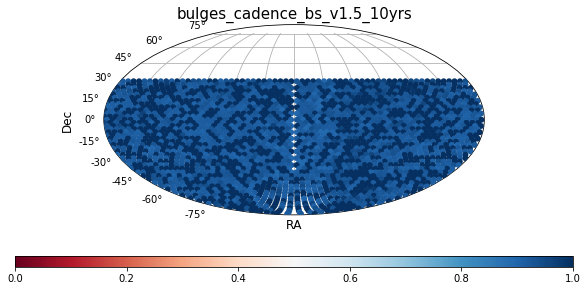

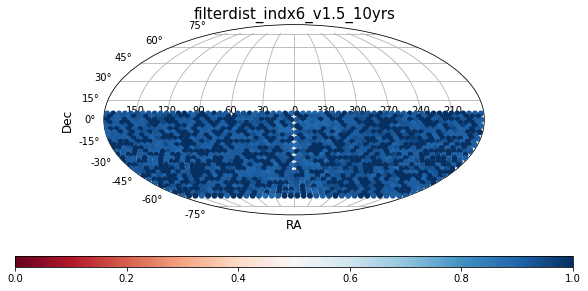

In [140]:
plt_mlw(RA1,Dec1,c=df[GOOD]['LSPMmetric']['detected'].values,vmin=0,vmax=1, dicts={'title':GOOD, 'colormap':'RdBu'})
plt_mlw(RA2,Dec2,c=df[BAD]['LSPMmetric']['detected'].values,vmin=0,vmax=1, dicts={'title':BAD, 'colormap':'RdBu'})

In [170]:
RA3,Dec3 = bundleDicts[GOOD][(2,'StarDensity ')].slicer.getSlicePoints()['ra'],bundleDicts[GOOD][(2,'StarDensity ')].slicer.getSlicePoints()['dec']
RA4,Dec4 = bundleDicts[BAD][(2,'StarDensity ')].slicer.getSlicePoints()['ra'],bundleDicts[BAD][(2,'StarDensity ')].slicer.getSlicePoints()['dec']

/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  


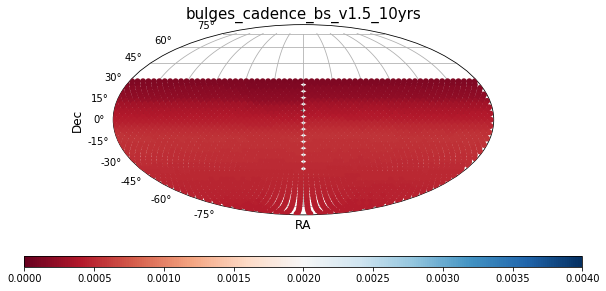

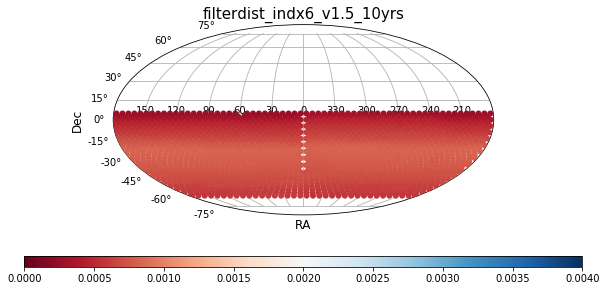

In [176]:
plt_mlw(RA1,Dec1,c=N[GOOD][0:len(RA1)],vmin=0,vmax=0.004, dicts={'title':GOOD, 'colormap':'RdBu'})
plt_mlw(RA2,Dec2,c=N[BAD][0:len(RA2)],vmin=0,vmax=0.004, dicts={'title':BAD, 'colormap':'RdBu'})

(array([ 58.,  89., 268., 309., 185.,  73.,  60.,  16.,  16.,   8.,   4.,
        789.]),
 array([0.88882089, 0.89808582, 0.90735074, 0.91661567, 0.92588059,
        0.93514552, 0.94441044, 0.95367537, 0.9629403 , 0.97220522,
        0.98147015, 0.99073507, 1.        ]),
 <a list of 12 Patch objects>)

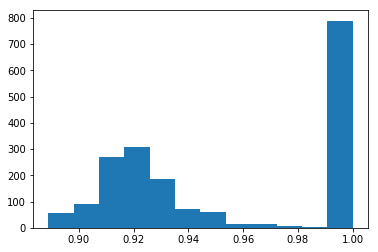

In [21]:
plt.hist(df['detected'].values,'auto')

In [9]:
bundleDicts['footprint_big_skyv1.5_10yrs']

{(1,
  'LSPMmetric'): <lsst.sims.maf.metricBundles.metricBundle.MetricBundle at 0x7fbb319965c0>,
 (2,
  'StarDensity '): <lsst.sims.maf.metricBundles.metricBundle.MetricBundle at 0x7fbb31926630>,
 (3,
  'TransienPM'): <lsst.sims.maf.metricBundles.metricBundle.MetricBundle at 0x7fbb31926da0>,
 (4,
  'confusionmetric'): <lsst.sims.maf.metricBundles.metricBundle.MetricBundle at 0x7fbb31926a20>,
 (5,
  'LSPMmetric'): <lsst.sims.maf.metricBundles.metricBundle.MetricBundle at 0x7fbb3192aa20>,
 (6,
  'StarDensity '): <lsst.sims.maf.metricBundles.metricBundle.MetricBundle at 0x7fbb31926d68>}

In [146]:
#b={BAD:bundleDicts[BAD],GOOD:bundleDicts[GOOD],'wfd_depth_scale0.99_noddf_v1.5_10yrs':bundleDicts['wfd_depth_scale0.99_noddf_v1.5_10yrs']}
b={BAD:bundleDicts[BAD],GOOD:bundleDicts[GOOD]}

In [145]:
#bundleDicts[GOOD][(5,
 # 'LSPMmetric')].setPlotDict({'cmap':'RdBu','colorMin':0,'colorMax':1,'title':GOOD+', detected fraction of novelties'})
#bundleDicts[BAD][(1,
#  'LSPMmetric')].setPlotDict({'cmap':'RdBu','colorMin':0,'colorMax':1,'title':BAD+', detected fraction of novelties'})
bundleDicts[GOOD][(2,
  'StarDensity ')].setPlotDict({'cmap':'RdBu','colorMin':0,'colorMax':1,'title':GOOD+', detected fraction of novelties'})
bundleDicts[BAD][(2,
  'StarDensity ')].setPlotDict({'cmap':'RdBu','colorMin':0,'colorMax':1,'title':BAD+', detected fraction of novelties'})

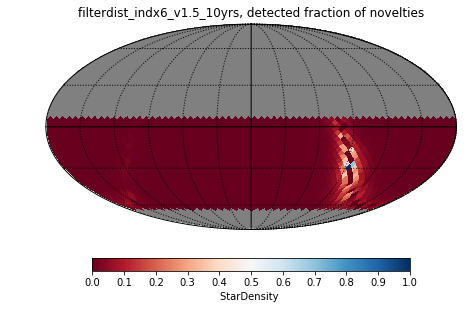

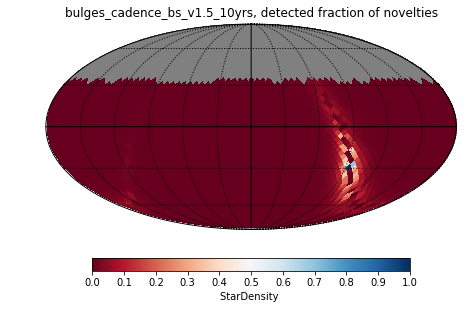

In [147]:
plotSky(b,(2,
  'StarDensity '))

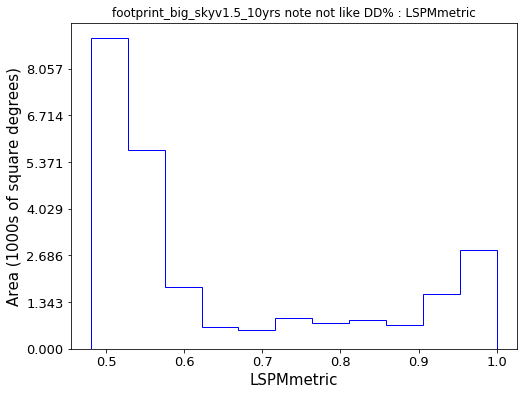

In [13]:
plotHist(b,(1,
  'LSPMmetric'),linewidth=3)

In [7]:
PPPP= pd.read_csv('simulation_pm.csv', usecols=['MAG','MODE','d','PM','PM_out'])

In [10]:
mag25,mag75= np.percentile(PPPP['MAG'],[25,75])
np.arange(min(PPPP['MAG']),max(PPPP['MAG']), mag75-mag25)

array([15.02608126, 17.15606575, 19.28605024, 21.41603473, 23.54601923])

In [ ]:
output= pd.concat([pd.DataFrame(lam[key]) for key in bundleDicts.keys()],axis=1)
output.columns=bundleDicts.keys()
output.to_csv('likelihood_score_DD.csv', index=False)

In [35]:
name_tick=[] 
for key in dbRuns:#bundleDicts.keys(): 
#if 'noddf' in key: 
#    continue 
#else: 
    n= key.split('_') 
    if 'v1.5' in n: 
        n.remove('v1.5') 
    else: 
        word=[] 
        for s in n[-2]: 
            word.append(s) 
            word[0].replace('v','') 
            word[0].replace('1','')  
            word[0].replace('.','')  
            word[0].replace('5','')  
        sub ='' 
        n[-2]= sub.join(word) 
    n.remove('10yrs') 
    s=' ' 
    name_tick.append(s.join(n))

In [898]:
FomLS=np.empty(len(dbRuns)) 
FomPMT=np.empty(len(dbRuns)) 
FomC =np.empty(len(dbRuns)) 
#for i, key in enumerate(bundleDicts.keys()): 
for i, key in enumerate(dbRuns): 
 #if 'noddf' in key: 
 #    continue 
 #else: 
    if len(pm[key])>0: 
        pm[key]=np.array(pm[key],dtype=np.float64)[~np.isnan(np.array(pm[key],dtype=np.float64))]
        ID_pm=np.where((pm[key]<1)) 
         #lv,lb =np.histogram(np.array(pm[key])[ID_pm],'auto') 
         #l_fom = (lb[1:len(lb)]+lb[0:len(lb)-1])/2*lv 
         #FomLS.append(l_fom.sum()/lv.sum()/(3*np.std(np.array(pm[key])[ID_pm]))*np.mean(np.array(pm[key])[ID_pm])) 
        FomLS[i] = np.median(np.array(pm[key])[ID_pm])/(3*np.std(1-np.array(pm[key])[ID_pm])) 
    else: 
         FomLS[i] = np.nan 
         #FomLS.append(0) 
    if len(conf[key])>0:     
        conf[key]=np.array(conf[key],dtype=np.float64)[~np.isnan(np.array(conf[key],dtype=np.float64))]
        ID_conf=np.where((conf[key]!=0)) 
         #cv,cb =np.histogram(np.array(conf[key])[ID_conf],'auto') 
         #c_fom = (cb[1:len(cb)]+cb[0:len(cb)-1])/2*cv 
         #FomC.append(c_fom.sum()/cv.sum()/(np.std(np.array(conf[key])[ID_conf]))*norm_coeff[i]) 
        FomC[i]=np.absolute(np.median(np.array(conf[key])[ID_conf])/(3*np.std(np.array(conf[key])[ID_conf])))#/norm_coeff[i]*(len(ID_conf)) 
    else: 
         FomC[i] = np.nan 
         #FomC.append(0) 
    if len(frac[key])>0: 
        frac[key]=np.array(frac[key],dtype=np.float64)[~np.isnan(np.array(frac[key],dtype=np.float64))]
        ID_frac=np.where((np.isnan(frac[key])==False)) 
         #fv,fb=np.histogram(np.array(frac[key])[ID_frac],'auto')  
         #f_fom = (fb[1:len(fb)]+fb[0:len(fb)-1])/2*fv    
         #FomPMT.append(f_fom.sum()/fv.sum()*np.mean(np.array(frac[key])[ID_frac]))#/(3*np.std(np.array(frac[key])[ID_frac]))) 
        FomPMT[i] = np.absolute(np.median(np.array(frac[key])[ID_frac]))/(3*np.std(np.array(frac[key])[ID_frac])) 
    else: 
         FomPMT[i] = np.nan 
         #FomPMT.append(0) 
#FomLS=np.array(FomLS) 
#FomPMT=np.array(FomPMT) 
#FomC= np.array(FomC) 
idx=np.argsort(FomC+FomPMT+FomLS) 
idx=idx[::-1]

In [912]:
ScoreLS= pd.DataFrame(FomLS/3) 
ScoreLS.to_csv('Score_LS.cvs',index=False) 
ScoreCI= pd.DataFrame(FomC/3) 
ScoreCI.to_csv('Score_CI.cvs',index=False) 
ScorePMT= pd.DataFrame(FomPMT/3) 
ScorePMT.to_csv('Score_PMT.cvs',index=False)

In [ ]:
FomLS = pd.read_csv('Score_LS.cvs') 
FomLS = np.array(FomLS['0']) 
FomC = pd.read_csv('Score_CI.cvs') 
FomC = np.array(FomC['0']) 
FomPMT = pd.read_csv('Score_PMT.cvs') 
FomPMT = np.array(FomPMT['0']) 
idx=np.argsort(FomC+FomPMT+FomLS) 
idx=idx[::-1]

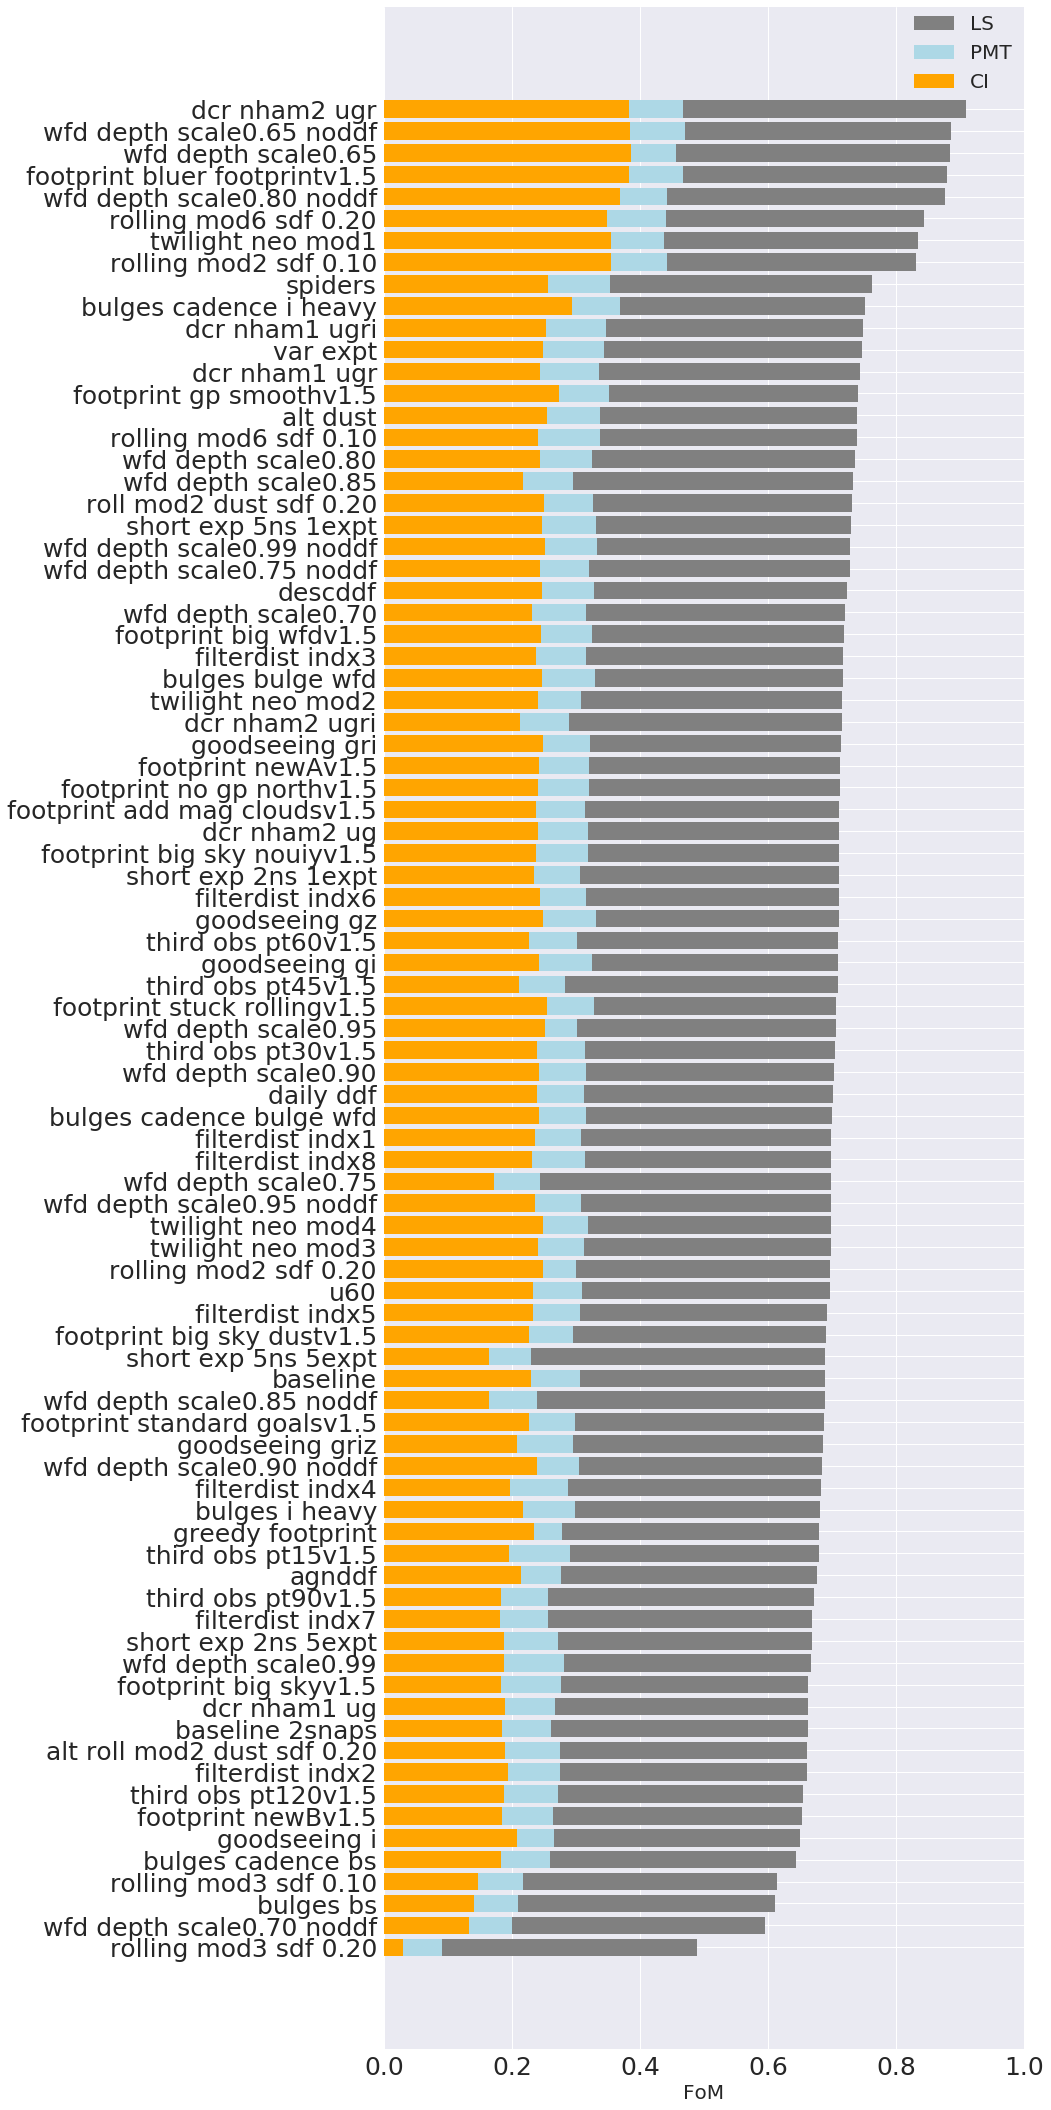

In [915]:
plt.style.use('seaborn') 
plt.rc('legend', fontsize=25) 
plt.rc('xtick',labelsize=25) 
fig, ax = plt.subplots(figsize=(15,30)) 
y_pos = np.arange(len(name_tick)) 
ax.barh(y_pos,(FomLS[idx]+FomC[idx]+FomPMT[idx])/3, align='center',color='grey',label='LS ') 
ax.barh(y_pos,(FomPMT[idx]+FomC[idx])/3, align='center',color='lightblue' ,label='PMT') 
ax.barh(y_pos,FomC[idx]/3, align='center', color= 'orange',label='CI') 
ax.set_xlim([0,1]) 
ax.set_yticks(y_pos[idx]) 
ax.set_yticklabels(name_tick, size=25) 
ax.invert_yaxis()  # labels read top-to-bottom 
ax.set_xlabel('FoM', size=20) 
ax.legend(bbox_to_anchor=(0.8, 0.95),fontsize=20) 
plt.tight_layout() 
#plt.savefig('FOM_astrometry_2yrs_v1p5.png')

In [902]:
df_plot = pd.DataFrame({'LS':FomLS/3,'CI':FomC/3,'PMT':FomPMT/3})

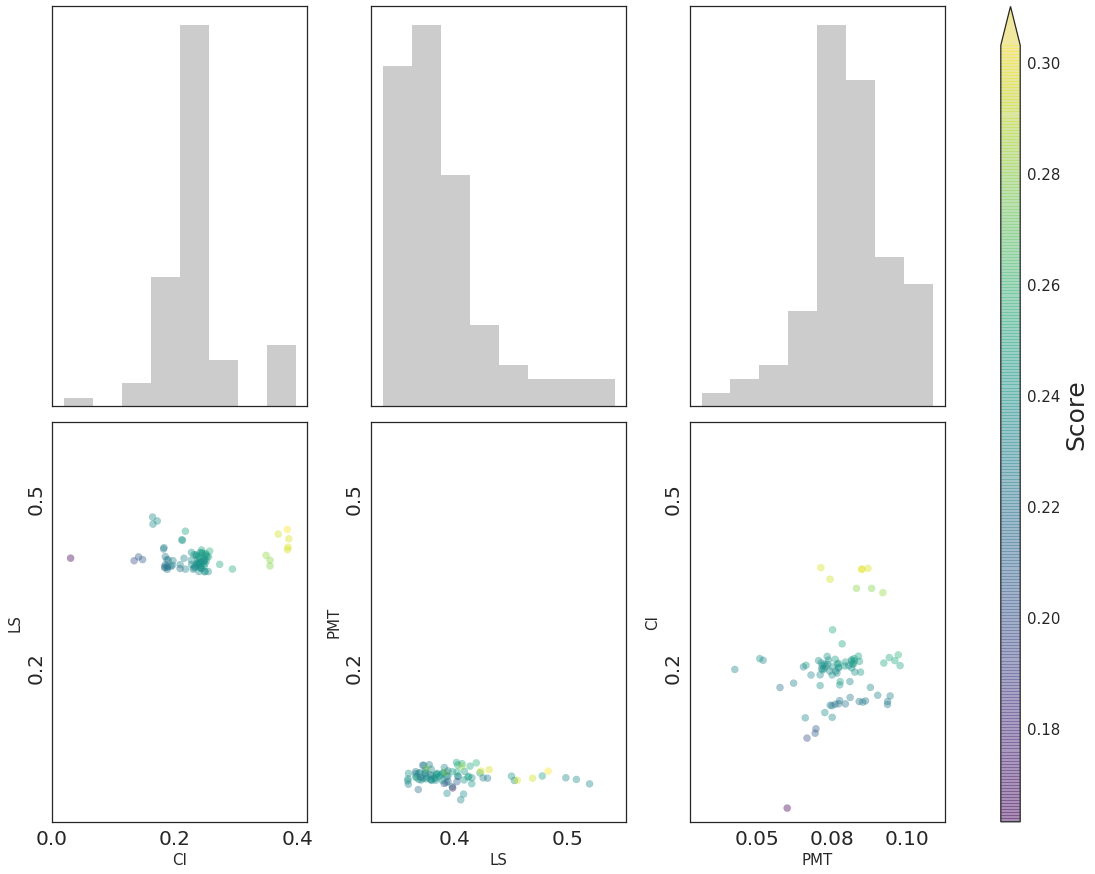

In [922]:
import matplotlib as mpl 
import seaborn as sns 
from scipy.stats import gaussian_kde
from matplotlib.ticker import FormatStrFormatter 
import matplotlib.gridspec as gridspec 
import matplotlib.ticker as plticker


mpl.rcParams.update({'font.size': 20}) 
#plt.rc('legend', fontsize=25) 
plt.rc('xtick',labelsize=20) 
plt.rc('ytick',labelsize=20) 
plt.rcParams['axes.grid']= False 
plt.rcParams['axes.edgecolor']= '0.15' 
plt.rcParams['axes.linewidth']= 1.25 
fig = plt.figure(figsize=(20,15)) 
grid = gridspec.GridSpec(2, 3, wspace=0.25, hspace=0.04) 
for i ,m in zip(np.arange(0,6,1), ['CI','LS','PMT']*2): 
    ax=plt.Subplot(fig, grid[i]) 
    if i in [0,1,2]: 
         #df_p=pd.DataFrame(df_plot[m]) 
        #sns.kdeplot(df_plot[m],color='gray', shade=True,ax=ax, alpha=0.3, legend=False) 
        sns.distplot(df_plot[m],color='gray',hist=True,kde=False,bins=8,ax=ax)
     #ax.hist(df_plot[m], bins='auto', histtype='step',lw=2,color='k') 
        ax.patch.set_facecolor('white') 
        ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f')) 
        ax.get_xaxis().set_visible(False) 
        ax.get_yaxis().set_visible(False) 
        fig.add_subplot(ax) 

    else: 
        if i ==3: 
            xy = np.vstack([df_plot['CI'],df_plot['LS']]) 
            z = gaussian_kde(xy)(xy) 
            ax.scatter(df_plot['CI'],df_plot['LS'],c=(df_plot['CI']+df_plot['PMT']+df_plot['LS'])/3, s=50,cmap='viridis', marker='o',alpha=.4) 
            ax.grid(False) 
            loc = plticker.MultipleLocator(base=0.25) # this locator puts ticks at regular intervals
            ax.yaxis.set_major_locator(loc)
            ax.set_ylim([0.01,0.6]) 
            ax.patch.set_facecolor('white') 
            ax.set_ylabel('LS', fontsize=15) 
            ax.set_xlabel('CI', fontsize=15) 
            #ax.xaxis.set_tick_params(rotation=90)
            ax.yaxis.set_tick_params(rotation=90)
            ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f')) 
            ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f')) 
        elif i ==4: 
            xy = np.vstack([df_plot['LS'],df_plot['PMT']]) 
            z = gaussian_kde(xy)(xy) 
            ax.scatter(df_plot['LS'],df_plot['PMT'], c=(df_plot['CI']+df_plot['PMT']+df_plot['LS'])/3,s=50,cmap='viridis', marker='o',alpha=.4) 
            ax.grid(False) 
            ax.set_ylim([0.01,0.6]) 
            loc = plticker.MultipleLocator(base=0.25) # this locator puts ticks at regular intervals
            ax.yaxis.set_major_locator(loc)
            ax.patch.set_facecolor('white') 
            ax.set_xlabel('LS', fontsize=15) 
            ax.set_ylabel('PMT', fontsize=15) 
            #ax.xaxis.set_tick_params(rotation=90)
            ax.yaxis.set_tick_params(rotation=90)
            ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f')) 
            ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f')) 
        elif i ==5: 
            xy = np.vstack([df_plot['LS'],df_plot['PMT']]) 
            z = gaussian_kde(xy)(xy) 
            ax.scatter(df_plot['PMT'],df_plot['CI'], c=(df_plot['CI']+df_plot['PMT']+df_plot['LS'])/3,s=50,cmap='viridis', marker='o',alpha=.4) 
            ax.grid(False)          
            ax.set_ylim([0.01,0.6]) 
            loc = plticker.MultipleLocator(base=0.25) # this locator puts ticks at regular intervals
            ax.yaxis.set_major_locator(loc)
            ax.set_xlabel('PMT', fontsize=15) 
            ax.set_ylabel('CI', fontsize=15) 
            ax.patch.set_facecolor('white') 
            #ax.xaxis.set_tick_params(rotation=90)
            ax.yaxis.set_tick_params(rotation=90)
            ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f')) 
            ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f')) 
        fig.add_subplot(ax) 

all_axes = fig.get_axes() 
cax,kw = mpl.colorbar.make_axes([axs for axs in all_axes], aspect=40) 
cbar= plt.colorbar(all_axes[3].get_children()[0],extend='max', cax=cax,**kw) 
#cbar.set_ticks([]) 
cbar.ax.tick_params(labelsize=15)  
cbar.set_label('Score', size=25) 
fig.tight_layout() 
fig.show() 
#fig.savefig('corner_score_v2.png')

### Likelihood Score distribution

In [541]:
point = metricSky1.slicer.getSlicePoints()

In [542]:
point

{'sid': array([0]), 'ra': array([2.61968193]), 'dec': array([0.03809775])}

In [660]:
bundleDicts

{'twilight_neo_mod2_v1.5_10yrs': {(1,
   'LSPMmetric'): <lsst.sims.maf.metricBundles.metricBundle.MetricBundle at 0x7f342d53abe0>,
  (2,
   'LSPMmetric'): <lsst.sims.maf.metricBundles.metricBundle.MetricBundle at 0x7f3430d0bf98>}}

In [630]:
pd.DataFrame(bundleDicts[key][(2,'LSPMmetric')].metricValues[np.where(bundleDicts[key][(2,'LSPMmetric')].metricValues.mask == False)])[0]

0    {'LS': {'L_PM': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
Name: 0, dtype: object

In [485]:
#position = [point['ra'][0], point['dec'][]]
position = galacticFromEquatorial(point['ra'][id_maxpos[0]], point['dec'][[id_maxpos[0]]])
print(position)

(array([98.36059661]), array([-59.93422644]))


/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  


In [465]:
data, hist  ={},{} 
for key in bundleDicts.keys(): 
    data[key]=pd.DataFrame(bundleDicts[key][(6,'LSPMmetric')].metricValues[np.where(bundleDicts[key][(1,'LSPMmetric')].metricValues.mask == False)])[0] 
    hist[key]={} 
    hist[key]['LS']=[] 
    hist[key]['LS_out']=[] 
    hist[key]['PM']=[] 
    hist[key]['PM_out']=[] 
    hist[key]['mag']=[] 
    for i in range(len(data[key])):         
        if data[key][i] is None: 
            continue
        else:
            for j in range(len(data[key][i]['LS']['L_PM'])): 
                hist[key]['LS'].append(data[key][i]['LS']['L_PM'][j]) 
            for k in range(len(data[key][i]['LS']['L_PMout'])): 
                hist[key]['LS_out'].append(data[key][i]['LS']['L_PMout'][k]) 
            for l in range(len(data[key][i]['LS']['mag'])): 
                hist[key]['mag'].append(data[key][i]['LS']['mag'][l]) 
            for j in range(len(data[key][i]['LS']['L_PM'])): 
                hist[key]['PM'].append(data[key][i]['LS']['PM'][j]) 
            for k in range(len(data[key][i]['LS']['PM_OUT'])): 
                hist[key]['PM_out'].append(data[key][i]['LS']['PM_OUT'][k])
    hist[key]['LS']=np.hstack(np.array(hist[key]['LS'])) 
    hist[key]['LS_out']=np.hstack(np.array(hist[key]['LS_out']))
    hist[key]['PM']=np.hstack(np.array(hist[key]['PM'])) 
    hist[key]['PM_out']=np.hstack(np.array(hist[key]['PM_out']))
    hist[key]['mag']=np.hstack(np.array(hist[key]['mag']))

KeyboardInterrupt: 

In [661]:
data[key]=pd.DataFrame(bundleDicts[key][(2,'LSPMmetric')].metricValues[np.where(bundleDicts[key][(2,'LSPMmetric')].metricValues.mask == False)])[0]
pos_pm = [] 
for i in range(np.size(data[key])):
    if (data[key][i] is None):
        continue
    else:
        m = np.mean(data[key][i]['LS']['PM'])
        if (len(data[key][i]['LS']['PM'])>1000):
            pos_pm.append([i,m])
pos_pm=np.array(pos_pm)

TypeError: 'float' object is not subscriptable

In [595]:
data[key][0:8]

0    {'LS': {'L_PM': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
1    {'LS': {'L_PM': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
2    {'LS': {'L_PM': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
3    {'LS': {'L_PM': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
4                                                 None
5    {'LS': {'L_PM': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
6    {'LS': {'L_PM': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
7    {'LS': {'L_PM': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
Name: twilight_neo_mod2_v1.5_10yrs, dtype: object

In [501]:
galacticFromEquatorial(29.01219,1.10383)

(154.36721781945494, -57.76975385626923)

In [492]:
id_maxpos = np.where(pos_pm[1:]==np.amax(pos_pm[1:]))
id_minpos = np.where(pos_pm[1:]==np.amin(pos_pm[1:]))

In [91]:
df=pd.DataFrame(hist[key])
df.to_csv('pm-sims.csv')

In [493]:
id_maxpos

(array([616]), array([0]))

In [292]:
position[1][0]

-25.662050800633242

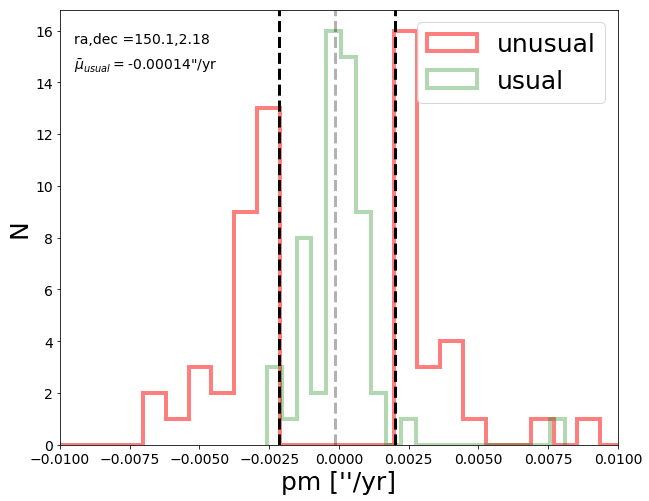

In [670]:
fig, ax= plt.subplots(figsize=(10,8))
plt.hist(data[key][0]['LS']['PM_OUT'], bins=50, color='red',histtype='step', lw=4,alpha =.5, label= 'unusual')
plt.hist(data[key][0]['LS']['PM'], bins=20, color='green',histtype='step',lw=4, alpha =.3, label='usual')
plt.xlabel('pm [\'\'/yr]', size=25)
plt.legend(loc='upper right',fontsize=25)
ax.tick_params(axis='both', which='major', labelsize=14)
plt.ylabel('N', size=25)
plt.xlim([-0.01,0.01])
#good=(data[key][0]['LS']['PM']< 0.03) & (hist[metric_runs[0]]['PM']>-0.03)
quant = np.percentile(data[key][0]['LS']['PM'],[2.5,97.5,50])
plt.text(-0.0095,15.5,'ra,dec ='+str(np.round(150.09671833,2))+','+str(np.round(2.18284020,2)),fontsize=14)
plt.text(-0.0095,14.5,r'$\bar{\mu}_{usual}=$'+str(np.round(quant[2],5))+'"/yr',fontsize=14)
plt.axvline(quant[2], color='k', alpha=.3, linestyle='dashed', linewidth=3)
plt.axvline(quant[0], color='k', linestyle='dashed', linewidth=3)
plt.axvline(quant[1], color='k', linestyle='dashed', linewidth=3)
#plt.ylim([0,12000])
plt.savefig('COSMOS_stream.png')
plt.show()

4.529540565264012e-05


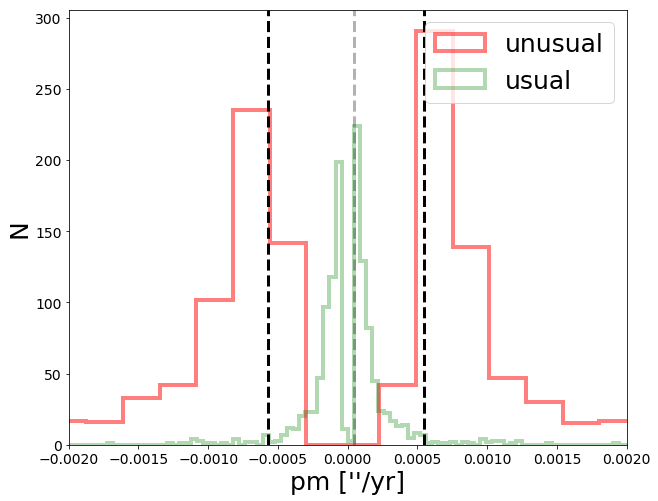

In [153]:
fig, ax= plt.subplots(figsize=(10,8))
plt.hist(data[key][6]['LS']['PM_OUT'], bins='auto', color='red',histtype='step', lw=4,alpha =.5, label= 'unusual')
plt.hist(data[key][6]['LS']['PM'], bins='auto', color='green',histtype='step',lw=4, alpha =.3, label='usual')
plt.xlabel('pm [\'\'/yr]', size=25)
plt.legend(fontsize=25)
ax.tick_params(axis='both', which='major', labelsize=14)
plt.ylabel('N', size=25)
plt.xlim([-0.002,0.002])
#good=(data[key][0]['LS']['PM']< 0.03) & (hist[metric_runs[0]]['PM']>-0.03)
quant = np.percentile(data[key][6]['LS']['PM'],[2.5,97.5,50])
print(quant[2])
plt.axvline(quant[2], color='k', alpha=.3, linestyle='dashed', linewidth=3)
plt.axvline(quant[0], color='k', linestyle='dashed', linewidth=3)
plt.axvline(quant[1], color='k', linestyle='dashed', linewidth=3)
#plt.ylim([0,12000])
#plt.savefig('uniform_pmunusual.png')
plt.show()

3.4925488723916454e-05


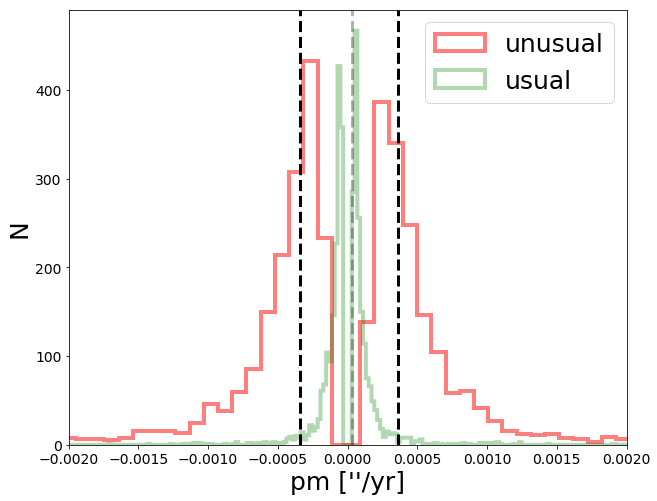

In [560]:
fig, ax= plt.subplots(figsize=(10,8))
plt.hist(data[key][0]['LS']['PM_OUT'], bins='auto', color='red',histtype='step', lw=4,alpha =.5, label= 'unusual')
plt.hist(data[key][0]['LS']['PM'], bins='auto', color='green',histtype='step',lw=4, alpha =.3, label='usual')
plt.xlabel('pm [\'\'/yr]', size=25)
plt.legend(fontsize=25)
ax.tick_params(axis='both', which='major', labelsize=14)
plt.ylabel('N', size=25)
plt.xlim([-0.002,0.002])
#good=(data[key][0]['LS']['PM']< 0.03) & (hist[metric_runs[0]]['PM']>-0.03)
quant = np.percentile(data[key][0]['LS']['PM'],[2.5,97.5,50])
print(quant[2])
plt.axvline(quant[2], color='k', alpha=.3, linestyle='dashed', linewidth=3)
plt.axvline(quant[0], color='k', linestyle='dashed', linewidth=3)
plt.axvline(quant[1], color='k', linestyle='dashed', linewidth=3)
#plt.ylim([0,12000])
#plt.savefig('uniform_pmunusual.png')
plt.show()

3.666374571350473e-05


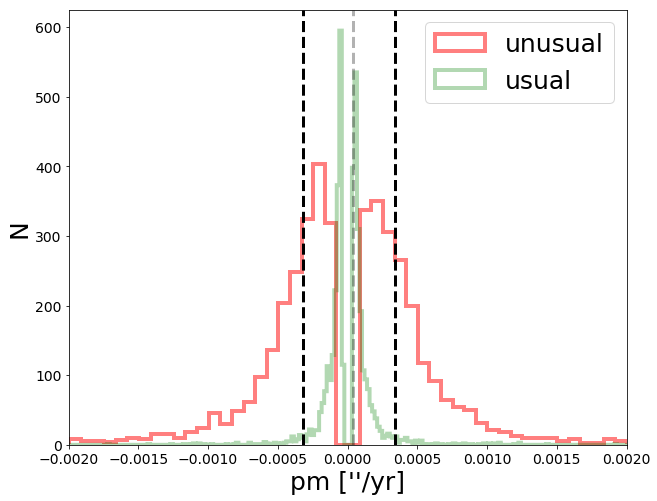

In [152]:
fig, ax= plt.subplots(figsize=(10,8))
plt.hist(data[key][1]['LS']['PM_OUT'], bins='auto', color='red',histtype='step', lw=4,alpha =.5, label= 'unusual')
plt.hist(data[key][1]['LS']['PM'], bins='auto', color='green',histtype='step',lw=4, alpha =.3, label='usual')
plt.xlabel('pm [\'\'/yr]', size=25)
plt.legend(fontsize=25)
ax.tick_params(axis='both', which='major', labelsize=14)
plt.ylabel('N', size=25)
plt.xlim([-0.002,0.002])
#good=(hist[metric_runs[0]]['PM']< 0.03) & (hist[metric_runs[0]]['PM']>-0.03)
quant = np.percentile(data[key][1]['LS']['PM'],[2.5,97.5,50])
print(quant[2])
plt.axvline(quant[2], color='k', alpha=.3, linestyle='dashed', linewidth=3)
plt.axvline(quant[0], color='k', linestyle='dashed', linewidth=3)
plt.axvline(quant[1], color='k', linestyle='dashed', linewidth=3)
#plt.ylim([0,12000])
#plt.savefig('uniform_pmunusual.png')
plt.show()

-0.00041445549656648356


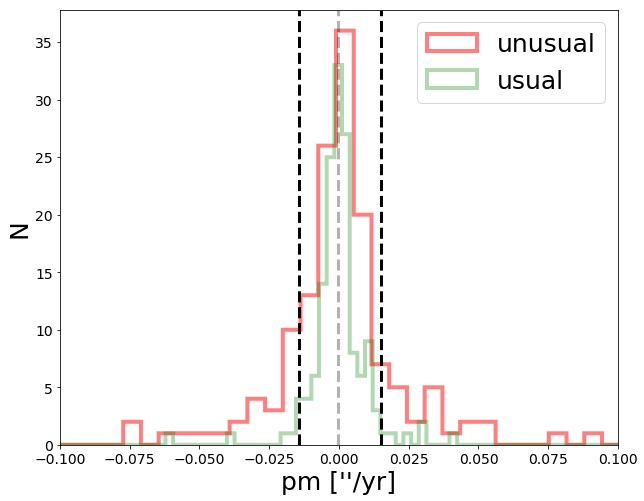

In [82]:
fig, ax= plt.subplots(figsize=(10,8))
plt.hist(hist[metric_runs[0]]['PM_out'], bins='auto', color='red',histtype='step', lw=4,alpha =.5, label= 'unusual')
plt.hist(hist[metric_runs[0]]['PM'], bins='auto', color='green',histtype='step',lw=4, alpha =.3, label='usual')
plt.xlabel('pm [\'\'/yr]', size=25)
plt.legend(fontsize=25)
ax.tick_params(axis='both', which='major', labelsize=14)
plt.ylabel('N', size=25)
plt.xlim([-0.1,0.1])
good=(hist[metric_runs[0]]['PM']< 0.03) & (hist[metric_runs[0]]['PM']>-0.03)
quant = np.percentile(hist[metric_runs[0]]['PM'][good],[2.5,97.5,50])
print(quant[2])
plt.axvline(quant[2], color='k', alpha=.3, linestyle='dashed', linewidth=3)
plt.axvline(quant[0], color='k', linestyle='dashed', linewidth=3)
plt.axvline(quant[1], color='k', linestyle='dashed', linewidth=3)
#plt.ylim([0,12000])
#plt.savefig('uniform_pmunusual.png')
plt.show()

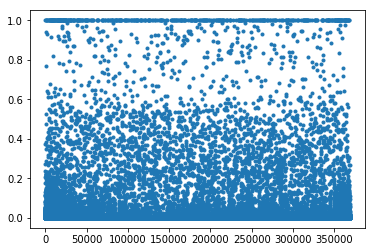

In [62]:
plt.plot(np.arange(len(hist[metric_runs[0]]['LS'][np.isfinite(hist[metric_runs[0]]['LS'])])),hist[metric_runs[0]]['LS'][np.isfinite(hist[metric_runs[0]]['LS'])],'.')

In [52]:
len(x)

1297

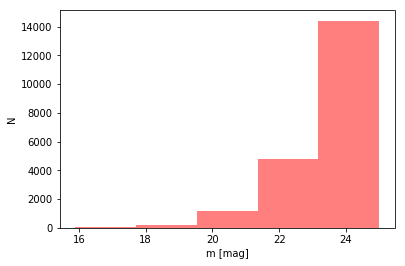

In [14]:
plt.hist(hist[metric_runs[0]]['mag'], bins=5, color='red', alpha =.5)
plt.xlabel('m [mag]')
plt.ylabel('N')
plt.show()

In [40]:
unusual=np.dstack((hist[metric_runs[0]]['PM_out'],hist[metric_runs[0]]['LS_out']))
usual=np.dstack((hist[metric_runs[0]]['PM'],hist[metric_runs[0]]['LS']))

In [41]:
bins_unusu=np.linspace(min(unusual[:,np.isfinite(hist[metric_runs[0]]['LS_out'])][0,:,0]),max(unusual[:,np.isfinite(hist[metric_runs[0]]['LS_out'])][0,:,0]), 1297)
index_unusu_bar=[np.where((unusual[:,np.isfinite(hist[metric_runs[0]]['LS_out'])][0,:,0]>bins_unusu[i])&(unusual[:,np.isfinite(hist[metric_runs[0]]['LS_out'])][0,:,0]<bins_unusu[i+1])) for i in range(len(bins_unusu)-1)] 
bins_usu=np.linspace(min(usual[:,np.isfinite(hist[metric_runs[0]]['LS'])][0,:,0]),max(usual[:,np.isfinite(hist[metric_runs[0]]['LS'])][0,:,0]), 1297)
index_usu_bar=[np.where((usual[:,np.isfinite(hist[metric_runs[0]]['LS'])][0,:,0]>bins_usu[i])&(usual[:,np.isfinite(hist[metric_runs[0]]['LS'])][0,:,0]<bins_usu[i+1])) for i in range(len(bins_usu)-1)] 
bar1_y = [np.sum(unusual[:,np.isfinite(hist[metric_runs[0]]['LS_out'])][0,index_unusu_bar[i],1]) for i in range(len(index_unusu_bar))]
bar2_y = [np.sum(usual[:,np.isfinite(hist[metric_runs[0]]['LS'])][0,index_usu_bar[i],1]) for i in range(len(index_usu_bar))]


In [42]:
from scipy import interpolate
p  = interpolate.splrep(bins_unusu[0:-1],bar1_y/np.nansum(bar1_y), s=0)
p2  = interpolate.splrep(bins_usu[0:-1],bar2_y/np.nansum(bar2_y), s=0)
y = interpolate.splev(np.arange(-1,1,0.01), p, der=0)
y2 = interpolate.splev(np.arange(-1,1,0.001), p2, der=0)

In [ ]:
from scipy import interpolate
p  = interpolate.splrep(hist[metric_runs[0]]['_out'],bar1_y/np.nansum(bar1_y), s=0)
p2  = interpolate.splrep(bins_usu[0:-1],bar2_y/np.nansum(bar2_y), s=5)
y = interpolate.splev(np.arange(-1,1,0.01), p, der=0)
y2 = interpolate.splev(np.arange(-1,1,0.01), p2, der=0)

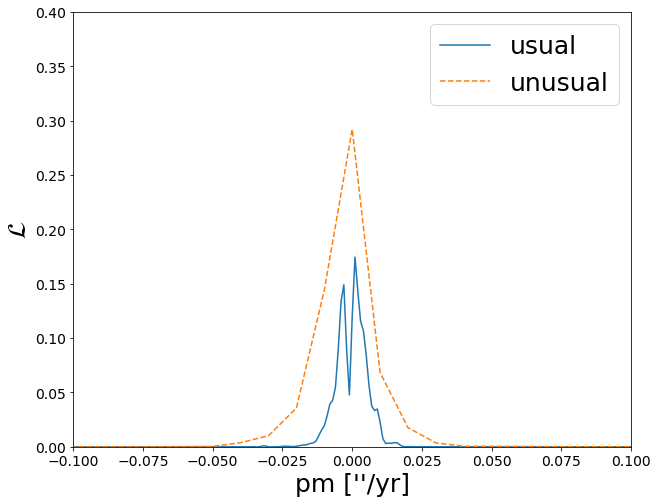

In [44]:
fig, ax= plt.subplots(figsize=(10,8))
plt.plot(np.arange(-1,1,0.001),y2,'-',label='usual')
plt.plot(np.arange(-1,1,0.01),y,'--', label='unusual')
plt.ylim([0,0.4])
plt.xlim([-0.1,0.1])
ax.tick_params(axis='both', which='major', labelsize=14)
plt.legend(fontsize=25)
plt.xlabel('pm [\'\'/yr]', size=25)
plt.ylabel(r'$\mathcal{L}$', size= 25)
#plt.savefig('uniform_likelihood.png')
plt.show()

In [100]:
valL_out[np.isfinite(valL_out)]/np.sum(valL_out[np.isfinite(valL_out)])

array([nan, nan, nan, ..., nan, nan, nan])

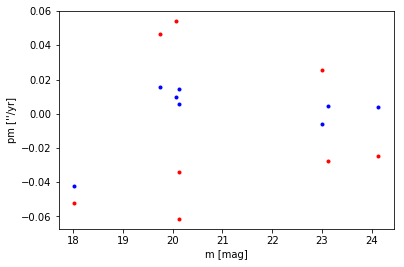

In [18]:
plt.plot(hist[metric_runs[0]]['mag'],hist[metric_runs[0]]['PM_out'],'r.')
plt.plot(hist[metric_runs[0]]['mag'],hist[metric_runs[0]]['PM'],'b.')
plt.ylabel('pm [\'\'/yr]')
plt.xlabel('m [mag]')
plt.show()

Text(0.5, 0.98, 'Baseline 2 yrs')

<Figure size 1440x720 with 0 Axes>

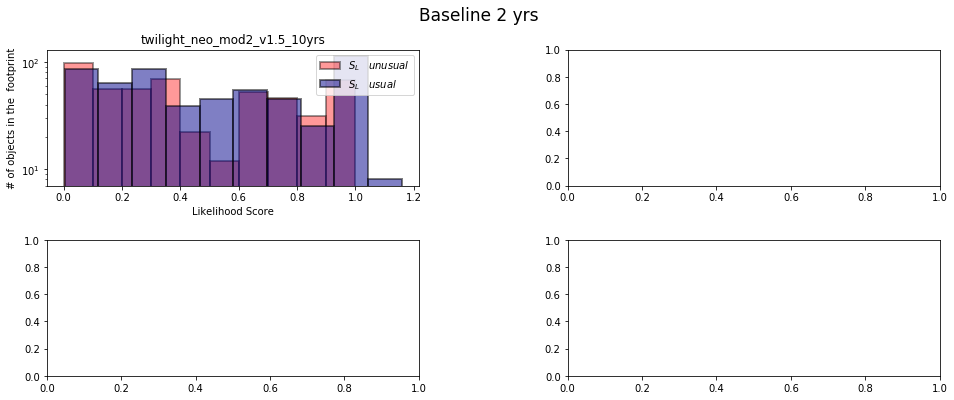

In [36]:
import seaborn as sn
fig = plt.figure(figsize=(20,10)) 
fig, ax = plt.subplots(2, 2, figsize=(16,6)) 
fig.subplots_adjust(hspace=0.4, wspace=0.4) 
for i, key in enumerate([metric_runs[0]]): 
 #value, bins = np.histogram(lam[key]['LS'], 50) 
 #v_out, b_out = np.histogram(lam[key]['LS_out'],10) 
 #ax = fig.add_subplot(2, 2, i+1) 
    zeromaskLS =np.isfinite(hist[key]['LS']) 
    plthist= pd.DataFrame(hist[key]['LS'][zeromaskLS]) 
    zeromask =np.isfinite(hist[key]['LS_out']) 
    plthistout= pd.DataFrame(hist[key]['LS_out'][zeromask]) 
    sn.distplot(plthistout[plthistout>0], color= 'red' ,  hist=True, kde=False,bins=10,norm_hist=False,hist_kws=dict(alpha=0.4,edgecolor='k' , linewidth=2), ax=ax[i // 2][i % 2], label=r'$S_L\hspace{1} unusual$') 
    sn.distplot(plthist[plthist>0], color= 'Darkblue' , hist=True, kde=False,bins=10,norm_hist=False,hist_kws=dict(alpha=0.5,edgecolor='k' , linewidth=2),ax=ax[i // 2][i % 2], label=r'$S_L\hspace{1} usual$') 
    #ax.hist(lam[key]['LS'],10,alpha=.3,histtype='step',lw=3, color='black', label='LS-usual') 
    #ax.hist(lam[key]['LS_out'],10,histtype='step',lw=3, color='orange', label='LS-unusual') 
    #ax[i // 2][i % 2].set_xlim([0,2]) 
    ax[i // 2][i % 2].set_yscale('log')
    ax[i // 2][i % 2].set_xlabel('Likelihood') 
    ax[i // 2][i % 2].set_ylabel('# of objects in the  footprint') 
    ax[i // 2][i % 2].set_title('{}'.format(metric_runs[i])) 
    if i ==0: 
        ax[i // 2][i % 2].legend() 
plt.suptitle('Baseline 2 yrs', size=17) 
#plt.savefig('hist_LS-dist.png')

### Sgr Simulation

In [ ]:
dataout_dens, cind_dens,H_dens,c_dens={},{},{},{}
for key in bundleDicts.keys():
    dataout_dens[key]=pd.DataFrame(bundleDicts[key][(1,'confusionmetric')].metricValues[np.where(bundleDicts[key][(1,'confusionmetric')].metricValues.mask == False)])[0]
    cind_dens[key]= {}
    H_dens[key]= {}
    c_dens[key]= {}
    for mag in dataout_dens[key][0].keys(): 
        cind_dens[key][mag] = []
        H_dens[key][mag] = []
        c_dens[key][mag] = []
    for i in range(len(dataout_dens[key])):        
        if dataout_dens[key][i]:
            for mag in dataout_dens[key][i].keys():
                cind_dens[key][mag].append(dataout_dens[key][i][mag]['num'])
                H_dens[key][mag].append(dataout_dens[key][i][mag]['Hg'])
                c_dens[key][mag].append(dataout_dens[key][i][mag]['g-r'])
    for mag in dataout_dens[key][0].keys(): 
        cind_dens[key][mag]=np.hstack(np.array(cind_dens[key][mag])[np.isfinite(np.array(cind_dens[key][mag]))])
        H_dens[key][mag]=np.hstack(np.array(H_dens[key][mag])[np.isfinite(np.array(H_dens[key][mag]))])
        c_dens[key][mag]=np.hstack(np.array(c_dens[key][mag])[np.isfinite(np.array(c_dens[key][mag]))])   

In [ ]:
dataout, cind_dist,H_dist,c_dist, label={},{},{},{},{}
for key in bundleDicts.keys():
    dataout[key]=pd.DataFrame(bundleDicts[key][(1,'confusionmetric')].metricValues[np.where(bundleDicts[key][(1,'confusionmetric')].metricValues.mask == False)])[0]
    cind_dist[key]= {}
    H_dist[key]= {}
    c_dist[key]= {}
    for mag in dataout[key][0].keys(): 
        cind_dist[key][mag] = []
        H_dist[key][mag] = []
        c_dist[key][mag] = []
    for i in range(len(dataout[key])):        
        if dataout[key][i]:
            for mag in dataout[key][i].keys():
                cind_dist[key][mag].append(dataout[key][i][mag]['num'])
                H_dist[key][mag].append(dataout[key][i][mag]['Hg'])
                c_dist[key][mag].append(dataout[key][i][mag]['g-r'])
    for mag in dataout[key][0].keys(): 
        cind_dist[key][mag]=np.hstack(np.array(cind_dist[key][mag])[np.isfinite(np.array(cind_dist[key][mag]))])
        H_dist[key][mag]=np.hstack(np.array(H_dist[key][mag])[np.isfinite(np.array(H_dist[key][mag]))])
        c_dist[key][mag]=np.hstack(np.array(c_dist[key][mag])[np.isfinite(np.array(c_dist[key][mag]))])
    

In [ ]:
import matplotlib as mpl
from itertools import product 
import matplotlib.gridspec as gridspec
for j, tup in enumerate([(3, 'PM2yrs')]):#enumerate([(2, 'PM5yrs'), (3, 'PM2yrs'), (4, 'PM1yrs'), (5, 'PM0p5yrs')]):
    mpl.rcParams.update({'font.size': 20})
    fig = plt.figure(figsize=(30,30))
    outer_grid = gridspec.GridSpec(4, 4, wspace=0.0, hspace=0.04)
    for i, (mag, key) in enumerate(product([0,1,2,3],dbRuns[0:4])):
        n=key.split('_')
        n.remove('v1.4')
        n.remove('10yrs')
        sep='_'
        name= sep.join(n)
        inner_grid = gridspec.GridSpecFromSubplotSpec(
          2, 1, subplot_spec=outer_grid[i], wspace=0.0, hspace=0.0)
        for j, mode in enumerate(['density','distance']):
            ax = plt.Subplot(fig, inner_grid[j])
            ax = plt.Subplot(fig, inner_grid[j], sharey=ax, sharex=ax)

            if mode=='density'and i>=4 and i not in [0,4,8,12,13,14,15]:
                try:
                    zero_mask = np.where(cind_dens[key][tup][mag]==0)
                    non_zero_mask = np.where(cind_dens[key][tup][mag]!=0)
                    plotdata=pd.DataFrame(np.matrix([H_dens[key][tup][mag][non_zero_mask],c_dens[key][tup][mag][non_zero_mask],cind_dens[key][tup][mag][non_zero_mask]]).T, columns=['Hg','g-r','detected in the 3sigma limit area'])
                    #zerodata=pd.DataFrame(np.matrix([H[key][mag][zero_mask],c[key][mag][zero_mask]]).T, columns=['Hg','g-r'])
                    im=plotdata.plot.scatter(x='g-r', y='Hg',c='detected in the 3sigma limit area', cmap='Spectral_r',s=40,colorbar=False, ax=ax,xlim=[0,2], ylim=[4,21],vmin=0,vmax=0.6, alpha=.2)

                    im.annotate('{} '.format(np.round(1-np.size(H_dist[key][tup][mag][zero_mask])/(np.size(H_dist[key][tup][mag])),2)),[1.7,6.7], size=20)
                    im.annotate('{},   dm={} mag,'.format(mode,mag),[0.05,6.7], size=20)
                    im.annotate('N = {} '.format(int(normdens_factor[key][tup][mag])-1),[0.05,8.5], size=20)
                    im.invert_yaxis()
                    im.set_ylabel('')
                    im.set_xlabel('')
                    im.get_xaxis().set_visible(False)
                    im.get_yaxis().set_visible(False)
                    fig.add_subplot(ax)
                except:
                    continue
            if mode=='distance'and i>=4 and i not in [0,4,8,12,13,14,15]:
                try:
                    zero_mask = np.where(cind_dist[key][tup][mag]==0)
                    non_zero_mask = np.where(cind_dist[key][tup][mag]!=0)
                    plotdata=pd.DataFrame(np.matrix([H_dens[key][tup][mag][non_zero_mask],c_dens[key][tup][mag][non_zero_mask],cind_dens[key][tup][mag][non_zero_mask]]).T, columns=['Hg','g-r','detected in the 3sigma limit area'])
                    #zerodata=pd.DataFrame(np.matrix([H[key][mag][zero_mask],c[key][mag][zero_mask]]).T, columns=['Hg','g-r'])
                    im=plotdata.plot.scatter(x='g-r', y='Hg',c='detected in the 3sigma limit area', cmap='Spectral_r',s=40,colorbar=False, ax=ax,xlim=[0,2], ylim=[4,21],vmin=0,vmax=0.6, alpha=.2)

                    im.annotate('{} '.format(np.round(1-np.size(H_dist[key][tup][mag][zero_mask])/(np.size(H_dist[key][tup][mag])),2)),[1.7,6.7], size=20)
                    im.annotate('{}, '.format(mode)  + r'$d_{new}=$'+'{} kpc,'.format(np.round(28*10**(mag/5),1)),[0.05,6.7], size=20)
                    im.annotate('N = {} '.format(int(normdist_factor[key][tup][mag])-1),[0.05,8.5], size=20)
                    im.invert_yaxis()
                    im.set_ylabel('')
                    im.set_xlabel('')
                    im.get_xaxis().set_visible(False)
                    im.get_yaxis().set_visible(False)
                    fig.add_subplot(ax)
                except:
                    continue

            elif mode=='density'and i in [4,8]:
                try:
                    zero_mask = np.where(cind_dens[key][tup][mag]==0)
                    non_zero_mask = np.where(cind_dens[key][tup][mag]!=0)
                    plotdata=pd.DataFrame(np.matrix([H_dens[key][tup][mag][non_zero_mask],c_dens[key][tup][mag][non_zero_mask],cind_dens[key][tup][mag][non_zero_mask]]).T, columns=['Hg','g-r','detected in the 3sigma limit area'])
                    #zerodata=pd.DataFrame(np.matrix([H[key][mag][zero_mask],c[key][mag][zero_mask]]).T, columns=['Hg','g-r'])
                    im=plotdata.plot.scatter(x='g-r', y='Hg',c='detected in the 3sigma limit area', cmap='Spectral_r',s=40,colorbar=False, ax=ax,xlim=[0,2], ylim=[4,21],vmin=0,vmax=0.6, alpha=.2)

                    im.annotate('{} '.format(np.round(1-np.size(H_dens[key][tup][mag][zero_mask])/(np.size(H_dens[key][tup][mag])),2)),[1.7,6.7], size=20)
                    im.annotate('{},   dm={} mag,'.format(mode,mag),[0.05,6.7], size=20)
                    im.annotate('N = {} '.format(int(normdens_factor[key][tup][mag])-1),[0.05,8.5], size=20)
                    im.invert_yaxis()
                    im.yaxis.set_label_coords(-0.15,0)
                    im.set_ylabel('Hg')
                    im.set_xlabel('')
                    im.get_xaxis().set_visible(False)
                    fig.add_subplot(ax)
                except:
                    continue
            elif mode=='distance'and i in [4,8]:
                try:
                    zero_mask = np.where(cind_dist[key][tup][mag]==0)
                    non_zero_mask = np.where(cind_dist[key][tup][mag]!=0)
                    plotdata=pd.DataFrame(np.matrix([H_dist[key][tup][mag][non_zero_mask],c_dist[key][tup][mag][non_zero_mask],cind_dist[key][tup][mag][non_zero_mask]]).T, columns=['Hg','g-r','detected in the 3sigma limit area'])
                    #zerodata=pd.DataFrame(np.matrix([H[key][mag][zero_mask],c[key][mag][zero_mask]]).T, columns=['Hg','g-r'])
                    im=plotdata.plot.scatter(x='g-r', y='Hg',c='detected in the 3sigma limit area', cmap='Spectral_r',s=40,colorbar=False, ax=ax,xlim=[0,2], ylim=[4,21],vmin=0,vmax=0.6, alpha=.2)

                    im.annotate('{} '.format(np.round(1-np.size(H_dist[key][tup][mag][zero_mask])/(np.size(H_dist[key][tup][mag])),2)),[1.7,6.7], size=20)
                    im.annotate('{}, '.format(mode)  + r'$d_{new}=$'+'{} kpc,'.format(np.round(28*10**(mag/5),1)),[0.05,6.7], size=20)
                    im.annotate('N = {} '.format(int(normdist_factor[key][tup][mag])-1),[0.05,8.5], size=20)
                    im.invert_yaxis()
                    im.yaxis.set_label_coords(-0.15,0)
                    im.set_ylabel('')
                    im.set_xlabel('')
                    im.get_xaxis().set_visible(False)
                    fig.add_subplot(ax)
                except:
                    continue
            elif mode=='density' and i in [1,2,3]:
                try:
                    zero_mask = np.where(cind_dens[key][tup][mag]==0)
                    non_zero_mask = np.where(cind_dens[key][tup][mag]!=0)
                    plotdata=pd.DataFrame(np.matrix([H_dens[key][tup][mag][non_zero_mask],c_dens[key][tup][mag][non_zero_mask],cind_dens[key][tup][mag][non_zero_mask]]).T, columns=['Hg','g-r','detected in the 3sigma limit area'])
                    #zerodata=pd.DataFrame(np.matrix([H[key][mag][zero_mask],c[key][mag][zero_mask]]).T, columns=['Hg','g-r'])
                    im=plotdata.plot.scatter(x='g-r', y='Hg',c='detected in the 3sigma limit area', cmap='Spectral_r',s=40,colorbar=False, ax=ax,xlim=[0,2], ylim=[4,21],vmin=0,vmax=0.6, alpha=.2,title='{} '.format(name))

                    im.annotate('{} '.format(np.round(1-np.size(H_dens[key][tup][mag][zero_mask])/(np.size(H_dens[key][tup][mag])),2)),[1.7,6.7], size=20)
                    im.annotate('{},   dm={} mag,'.format(mode,mag),[0.05,6.7], size=20)
                    im.annotate('N = {} '.format(int(normdens_factor[key][tup][mag])-1),[0.05,8.5], size=20)
                    im.invert_yaxis()
                    im.set_ylabel('')
                    im.set_xlabel('')
                    im.get_xaxis().set_visible(False)
                    im.get_yaxis().set_visible(False)
                    fig.add_subplot(ax)
                except:
                    continue
            elif mode=='distance' and i in [1,2,3]:
                try:
                    zero_mask = np.where(cind_dist[key][tup][mag]==0)
                    non_zero_mask = np.where(cind_dist[key][tup][mag]!=0)
                    plotdata=pd.DataFrame(np.matrix([H_dist[key][tup][mag][non_zero_mask],c_dist[key][tup][mag][non_zero_mask],cind_dist[key][tup][mag][non_zero_mask]]).T, columns=['Hg','g-r','detected in the 3sigma limit area'])
                    #zerodata=pd.DataFrame(np.matrix([H[key][mag][zero_mask],c[key][mag][zero_mask]]).T, columns=['Hg','g-r'])
                    im=plotdata.plot.scatter(x='g-r', y='Hg',c='detected in the 3sigma limit area', cmap='Spectral_r',s=40,colorbar=False, ax=ax,xlim=[0,2], ylim=[4,21],vmin=0,vmax=0.6, alpha=.2)
                    im.annotate('{} '.format(np.round(1-np.size(H_dist[key][tup][mag][zero_mask])/(np.size(H_dist[key][tup][mag])),2)),[1.7,6.7], size=20)
                    im.annotate('{}, '.format(mode)  + r'$d_{new}=$'+'{} kpc,'.format(np.round(28*10**(mag/5),1)),[0.05,6.7], size=20)
                    im.annotate('N = {} '.format(int(normdist_factor[key][tup][mag])-1),[0.05,8.5], size=20)
                    im.invert_yaxis()
                    im.set_ylabel('')
                    im.set_xlabel('')
                    im.get_xaxis().set_visible(False)
                    im.get_yaxis().set_visible(False)
                    fig.add_subplot(ax)
                except:
                    continue
            elif mode=='density' and i==0:
                try:
                    zero_mask = np.where(cind_dens[key][tup][mag]==0)
                    non_zero_mask = np.where(cind_dens[key][tup][mag]!=0)
                    plotdata=pd.DataFrame(np.matrix([H_dens[key][tup][mag][non_zero_mask],c_dens[key][tup][mag][non_zero_mask],cind_dens[key][tup][mag][non_zero_mask]]).T, columns=['Hg','g-r','detected in the 3sigma limit area'])
                    #zerodata=pd.DataFrame(np.matrix([H[key][mag][zero_mask],c[key][mag][zero_mask]]).T, columns=['Hg','g-r'])
                    im=plotdata.plot.scatter(x='g-r', y='Hg',c='detected in the 3sigma limit area', cmap='Spectral_r',s=40,colorbar=False, ax=ax,xlim=[0,2], ylim=[4,21],vmin=0,vmax=0.6, alpha=.2,title='{} '.format(name))

                    im.annotate('{} '.format(np.round(1-np.size(H_dens[key][tup][mag][zero_mask])/(np.size(H_dens[key][tup][mag])),2)),[1.7,6.7], size=20)
                    im.annotate('{},   dm={} mag,'.format(mode,mag),[0.05,6.7], size=20)
                    im.annotate('N = {} '.format(int(normdens_factor[key][tup][mag])-1),[0.05,8.5], size=20)
                    im.yaxis.set_label_coords(-0.15,0)
                    im.set_ylabel('Hg')
                    im.set_xlabel('')
                    im.invert_yaxis()
                    im.get_xaxis().set_visible(False)
                    fig.add_subplot(ax)
                except:
                    continue
            elif mode=='distance' and i==0:
                try:
                    zero_mask = np.where(cind_dist[key][tup][mag]==0)
                    non_zero_mask = np.where(cind_dist[key][tup][mag]!=0)
                    plotdata=pd.DataFrame(np.matrix([H_dist[key][tup][mag][non_zero_mask],c_dist[key][tup][mag][non_zero_mask],cind_dist[key][tup][mag][non_zero_mask]]).T, columns=['Hg','g-r','detected in the 3sigma limit area'])
                    #zerodata=pd.DataFrame(np.matrix([H[key][mag][zero_mask],c[key][mag][zero_mask]]).T, columns=['Hg','g-r'])
                    im=plotdata.plot.scatter(x='g-r', y='Hg',c='detected in the 3sigma limit area', cmap='Spectral_r',s=40,colorbar=False, ax=ax,xlim=[0,2], ylim=[4,21],vmin=0,vmax=0.6, alpha=.2)

                    im.annotate('{} '.format(np.round(1-np.size(H_dist[key][tup][mag][zero_mask])/(np.size(H_dist[key][tup][mag])),2)),[1.7,6.7], size=20)
                    im.annotate('{}, '.format(mode)  + r'$d_{new}=$'+'{} kpc,'.format(np.round(28*10**(mag/5),1)),[0.05,6.7], size=20)
                    im.annotate('N = {} '.format(int(normdist_factor[key][tup][mag])-1),[0.05,8.5], size=20)
                    im.yaxis.set_label_coords(-0.15,0)
                    im.set_ylabel('')
                    im.set_xlabel('')
                    im.invert_yaxis()
                    im.get_xaxis().set_visible(False)
                    fig.add_subplot(ax)
                except:
                    continue
            elif mode=='density'and i==12:
                try:
                    zero_mask = np.where(cind_dens[key][tup][mag]==0)
                    non_zero_mask = np.where(cind_dens[key][tup][mag]!=0)
                    plotdata=pd.DataFrame(np.matrix([H_dens[key][tup][mag][non_zero_mask],c_dens[key][tup][mag][non_zero_mask],cind_dens[key][tup][mag][non_zero_mask]]).T, columns=['Hg','g-r','detected in the 3sigma limit area'])
                    #zerodata=pd.DataFrame(np.matrix([H[key][mag][zero_mask],c[key][mag][zero_mask]]).T, columns=['Hg','g-r'])
                    im=plotdata.plot.scatter(x='g-r', y='Hg',c='detected in the 3sigma limit area', cmap='Spectral_r',s=40,colorbar=False, ax=ax,xlim=[0,2], ylim=[4,21],vmin=0,vmax=0.6, alpha=.2)

                    im.annotate('{} '.format(np.round(1-np.size(H_dens[key][tup][mag][zero_mask])/(np.size(H_dens[key][tup][mag])),2)),[1.7,6.7], size=20)
                    im.annotate('{},   dm={} mag,'.format(mode,mag),[0.05,6.7], size=20)
                    im.annotate('N = {} '.format(int(normdens_factor[key][tup][mag])-1),[0.05,8.5], size=20)
                    im.invert_yaxis()
                    im.yaxis.set_label_coords(-0.15,0)
                    im.set_ylabel('Hg')
                    im.set_xlabel('')
                    fig.add_subplot(ax)
                except:
                    continue
            if mode=='distance'and i==12:
                try:
                    zero_mask = np.where(cind_dist[key][tup][mag]==0)
                    non_zero_mask = np.where(cind_dist[key][tup][mag]!=0)
                    plotdata=pd.DataFrame(np.matrix([H_dist[key][tup][mag][non_zero_mask],c_dist[key][tup][mag][non_zero_mask],cind_dist[key][tup][mag][non_zero_mask]]).T, columns=['Hg','g-r','detected in the 3sigma limit area'])
                    #zerodata=pd.DataFrame(np.matrix([H[key][mag][zero_mask],c[key][mag][zero_mask]]).T, columns=['Hg','g-r'])
                    im=plotdata.plot.scatter(x='g-r', y='Hg',c='detected in the 3sigma limit area', cmap='Spectral_r',s=40,colorbar=False, ax=ax,xlim=[0,2], ylim=[4,21],vmin=0,vmax=0.6, alpha=.2)

                    im.annotate('{} '.format(np.round(1-np.size(H_dist[key][tup][mag][zero_mask])/(np.size(H_dist[key][tup][mag])),2)),[1.7,6.7], size=20)
                    im.annotate('{}, '.format(mode)  + r'$d_{new}=$'+'{} kpc,'.format(np.round(28*10**(mag/5),1)),[0.05,6.7], size=20)
                    im.annotate('N = {} '.format(int(normdist_factor[key][tup][mag])-1),[0.05,8.5], size=20)
                    im.invert_yaxis()
                    im.set_xlim([0,1.9])
                    im.yaxis.set_label_coords(-0.15,0)
                    im.set_ylabel('')
                    fig.add_subplot(ax)  
                except:
                    continue
            elif mode== 'distance' and i in [13,14,15]:
                try:
                    zero_mask = np.where(cind_dist[key][tup][mag]==0)
                    non_zero_mask = np.where(cind_dist[key][tup][mag]!=0)
                    plotdata=pd.DataFrame(np.matrix([H_dist[key][tup][mag][non_zero_mask],c_dist[key][tup][mag][non_zero_mask],cind_dist[key][tup][mag][non_zero_mask]]).T, columns=['Hg','g-r','detected in the 3sigma limit area'])
                    #zerodata=pd.DataFrame(np.matrix([H[key][mag][zero_mask],c[key][mag][zero_mask]]).T, columns=['Hg','g-r'])
                    im=plotdata.plot.scatter(x='g-r', y='Hg',c='detected in the 3sigma limit area', cmap='Spectral_r',s=40,colorbar=False, ax=ax,xlim=[0,2], ylim=[4,21],vmin=0,vmax=0.6, alpha=.2)
                    im.annotate('{} '.format(np.round(1-np.size(H_dist[key][tup][mag][zero_mask])/(np.size(H_dist[key][tup][mag])),2)),[1.7,6.7], size=20)
                    im.annotate('{}, '.format(mode)  + r'$d_{new}=$'+'{} kpc,'.format(np.round(28*10**(mag/5),1)),[0.05,6.7], size=20)
                    im.annotate('N = {} '.format(int(normdist_factor[key][tup][mag])-1),[0.05,8.5], size=20)
                    im.set_ylabel('')
                    im.set_xlim([0,1.9])
                    im.invert_yaxis()
                    im.get_yaxis().set_visible(False)
                    fig.add_subplot(ax)
                except:
                    continue
            elif mode== 'density' and i in [13,14,15]:
                try:
                    zero_mask = np.where(cind_dens[key][tup][mag]==0)
                    non_zero_mask = np.where(cind_dens[key][tup][mag]!=0)
                    plotdata=pd.DataFrame(np.matrix([H_dens[key][tup][mag][non_zero_mask],c_dens[key][tup][mag][non_zero_mask],cind_dens[key][tup][mag][non_zero_mask]]).T, columns=['Hg','g-r','detected in the 3sigma limit area'])
                    #zerodata=pd.DataFrame(np.matrix([H[key][mag][zero_mask],c[key][mag][zero_mask]]).T, columns=['Hg','g-r'])
                    im=plotdata.plot.scatter(x='g-r', y='Hg',c='detected in the 3sigma limit area', cmap='Spectral_r',s=40,colorbar=False, ax=ax,xlim=[0,2], ylim=[4,21],vmin=0,vmax=0.6, alpha=.2)
                    im.annotate('{} '.format(np.round(1-np.size(H_dens[key][tup][mag][zero_mask])/(np.size(H_dens[key][tup][mag])),2)),[1.7,6.7], size=20)
                    im.annotate('{},   dm={} mag,'.format(mode,mag),[0.05,6.7], size=20)
                    im.annotate('N = {} '.format(int(normdens_factor[key][tup][mag])-1),[0.05,8.5], size=20)
                    im.set_ylabel('')
                    im.invert_yaxis()
                    im.get_yaxis().set_visible(False)
                    im.get_xaxis().set_visible(False)
                    fig.add_subplot(ax)
                except:
                    continue
    plt.suptitle("ConfunsionIndex {}".format(tup[1]))
    all_axes = fig.get_axes()
    fig.tight_layout()
    cax,kw = mpl.colorbar.make_axes([axs for axs in all_axes], aspect=40)
    cbar= plt.colorbar(all_axes[0].get_children()[0], extend= 'max',cax=cax,**kw)
    cbar.ax.set_ylabel('Confusion Index', size=30)
    fig.savefig("ConfunsionIndex_{}.png".format(tup[1]))


In [109]:
dvel= pd.read_csv('v_hel.csv')
drpm = pd.read_csv('data.csv')

In [170]:
val, bins=np.histogram(np.array(dvel['VHEL'])[np.where(dvel['VHEL']<500)],bins='auto')

In [192]:
def Gauss2(x,A1,A2,mu1,mu2,sigma1,sigma2):
    return A1*np.exp(-0.5*((mu1-x)/sigma1)**2)+A2*np.exp(-0.5*((mu2-x)/sigma2)**2)

In [193]:
from scipy.optimize import curve_fit 

In [196]:
fit, cov = curve_fit(Gauss2, bins[0:-1],val,p0=[1,1,np.mean(bins),np.mean(bins),np.std(bins),np.std(bins)])

In [197]:
fit

array([ 51.02292506,  17.14810292,  -9.78277474, -97.29040162,
       -32.25334926, 106.91821735])

In [206]:
vel_unusual =np.exp(-0.5*((fit[3]-np.arange(-500,300,1))/fit[5])**2)

In [208]:
vel_unusual= pd.DataFrame({'vel':np.arange(-500,300,1),'fraction':vel_unusual})

In [211]:
vel_unusual.to_csv('unusual_stream.csv', index=False)